# Import

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LassoCV, ElasticNetCV
from scipy import stats
import itertools 
from tqdm import tqdm
from itertools import combinations 
import functions as f
import help_function as hf
import warnings
import time
from matplotlib.lines import Line2D

### Data Import

In [2]:
# Import weekly data as data_w
data_w = pd.read_csv('data/data_weekly.csv')
data_w.replace([np.inf, -np.inf], np.nan, inplace=True)
data_w.ffill(inplace=True)
data_w.dropna(inplace=True)
pd.to_datetime(data_w['DATE'])
data_w.index = data_w['DATE']
data_w = data_w.drop(['DATE'],axis=1)

# Import X matrix
X = pd.read_csv('data/X.csv')
pd.to_datetime(X['DATE'])
X.index = X['DATE']
X = X.drop(['DATE'],axis=1)
X.dropna(inplace = True)

# Import y matrix
y = pd.read_csv('data/y_MOM.csv')
pd.to_datetime(y['DATE'])
y.index = y['DATE']
y = y.drop(['DATE'],axis=1)
y.dropna(inplace = True)

# Data visualisation

In [3]:
X.head(2000)

,VIX,CS,GDP,IR,CPI,Liquidity,PUT/CALL,Crude Oil,VIX_return,CS_return,...,Crude_Oil_return,GDP_return,VIX_log_return,CS_log_return,IR_log_return,CPI_log_return,Liquidity_log_return,PUT/CALL_log_return,Crude_Oil_log_return,GDP_log_return
DATE,,,,,,,,,,,,,,,,,,,,,
2005-01-16,-0.901498,-1.009775,0.947275,1.242432,0.400918,-0.777029,-0.111518,-1.238808,-0.801537,-0.694689,...,1.701018,0.01603,-0.800140,-0.689801,-0.347395,-0.058831,-2.042180,-1.038852,1.663446,0.001598
2005-01-23,-0.769957,-1.043890,0.947275,1.191098,0.400918,-0.785507,0.365590,-1.193567,0.660167,-0.442663,...,0.516996,0.01603,0.698080,-0.433986,-0.413693,-0.058831,0.565970,0.568339,0.527189,0.001598
2005-01-30,-0.767272,-1.098165,0.947275,1.191247,0.400918,-0.683773,-0.424105,-1.187776,-0.017101,-0.726520,...,0.029143,0.01603,0.698080,-0.433986,-0.413693,-0.058831,0.565970,0.568339,0.527189,0.001598
2005-02-06,-1.062122,-1.178585,0.947275,1.143786,0.234252,-0.696490,-1.263156,-1.258062,-1.480408,-1.107797,...,-0.889671,0.01603,-1.574660,-1.112448,-0.387900,-1.834630,-1.604221,-1.178653,-0.882376,0.001598
2005-02-13,-1.080018,-1.287037,0.947275,1.088800,0.234252,-0.789746,-0.012806,-1.281081,-0.132497,-1.543677,...,-0.327134,0.01603,-1.574660,-1.112448,-0.387900,-1.834630,-1.604221,-1.178653,-0.882376,0.001598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-27,0.144792,-1.385404,-0.143369,1.249779,-0.074311,-1.094947,-1.180896,-0.019915,0.186635,-0.791403,...,0.307327,0.01603,0.235370,-0.788375,1.167805,-0.058831,2.309232,0.161232,0.321323,0.001598
2024-11-03,0.422416,-1.385404,-0.143369,1.343013,-0.021901,-1.048319,0.217522,-0.150353,0.925379,-1.824852,...,-1.106709,0.01603,0.948721,-1.856098,0.710258,0.640070,-0.528419,1.799527,-1.106003,0.001598
2024-11-10,-0.238199,-1.385404,-0.143369,1.336771,0.017407,-1.056797,-0.934116,-0.022086,-1.624769,-0.268539,...,1.046337,0.01603,-1.746871,-0.258132,-0.057127,0.449243,0.101291,-1.503913,1.040607,0.001598


In [4]:
y.head(2000)

,MOM_log_return
DATE,
2005-01-16,0.283703
2005-01-23,-0.198823
2005-01-30,-0.198823
2005-02-06,1.499657
2005-02-13,1.499657
...,...
2024-10-27,-0.692673
2024-11-03,-0.962297
2024-11-10,0.933193


# Lasso & Elastic Net

In this section, Lasso & Elatic Net are performed to reduce the number of feauture to improve the MRSM Model

## Lasso

In [5]:
 y_L = y['MOM_log_return']

# Lasso Regression with Cross-Validation
lasso = LassoCV(alphas = [0.05,0.1], max_iter=1000)
lasso.fit(X, y_L)
lasso_selected_features = np.where(lasso.coef_ != 0)[0]

print("Lasso selected feature indices:", lasso_selected_features)
print("Lasso selected features:", X.columns[lasso_selected_features])
print("Best Lasso alpha:", lasso.alpha_)

Lasso selected feature indices: [ 0  4  6 10 16 17 22]
Lasso selected features: Index(['VIX', 'CPI', 'PUT/CALL', 'IR_return', 'VIX_log_return',
       'CS_log_return', 'Crude_Oil_log_return'],
      dtype='object')
Best Lasso alpha: 0.05


## Elastic Net

In [6]:
# Elastic Net Regression with Cross-Validation
elastic_net = ElasticNetCV(alphas = [0.05,0.1], max_iter=1000)
elastic_net.fit(X, y_L)
elastic_net_selected_features = np.where(elastic_net.coef_ != 0)[0]

print("Elastic Net selected feature indices:", elastic_net_selected_features)
print("Elastic Net selected features:", X.columns[elastic_net_selected_features])
print("Best Elastic Net alpha:", elastic_net.alpha_)
print("Best Elastic Net l1_ratio:", elastic_net.l1_ratio_)

Elastic Net selected feature indices: [ 0  2  3  4  5  6  8 10 16 17 22]
Elastic Net selected features: Index(['VIX', 'GDP', 'IR', 'CPI', 'Liquidity', 'PUT/CALL', 'VIX_return',
       'IR_return', 'VIX_log_return', 'CS_log_return', 'Crude_Oil_log_return'],
      dtype='object')
Best Elastic Net alpha: 0.05
Best Elastic Net l1_ratio: 0.5


## Best AIC & BIC algorithm

The final selected combination of algorithms is the Elastic Net and AIC optimization. It returns the best model fitting results.

In [7]:
#AIC
#results_lasso_aic = f.best_AIC_algorithm(y, X, lasso_selected_features)
#print(results_lasso_aic)

results_elastic_aic = f.best_AIC_algorithm(y, X, elastic_net_selected_features)
print(results_elastic_aic)

#BIC
#results_lasso_bic = f.best_BIC_algorithm(y, X, lasso_selected_features)
#print(results_lasso_bic)

#results_elastic_bic = f.best_BIC_algorithm(y, X, elastic_net_selected_features)
#print(results_elastic_bic)


--- AIC Optimization Results ---
Best Feature Combination:
VIX_log_return, Crude_Oil_log_return, PUT/CALL, IR_return, IR, CS_log_return, CPI, GDP, VIX, Liquidity
Lowest AIC: 1907.2149

All AIC Results:
Features: VIX_log_return, Crude_Oil_log_return, PUT/CALL, IR_return, IR, CS_log_return, CPI, GDP, VIX, Liquidity | AIC: 1907.2149
Features: VIX_log_return, Crude_Oil_log_return, PUT/CALL, IR_return, IR, CS_log_return, CPI, GDP, VIX, Liquidity, VIX_return | AIC: 1911.6806
Features: VIX_log_return, Crude_Oil_log_return, PUT/CALL, IR_return, IR, CS_log_return, CPI, GDP, VIX | AIC: 1916.1572
Features: VIX_log_return, Crude_Oil_log_return, PUT/CALL, IR_return, IR, CS_log_return, CPI, GDP | AIC: 1917.4019
Features: VIX_log_return, Crude_Oil_log_return, PUT/CALL, IR_return, IR, CS_log_return, CPI, GDP, VIX, VIX_return | AIC: 1919.1177
Features: VIX_log_return, Crude_Oil_log_return, PUT/CALL, IR_return, IR, CS_log_return, CPI, GDP, Liquidity | AIC: 1919.6274
Features: VIX_log_return, Crude_Oil_

# Variable selection

Find below all the algorithms combination with their AIC, BIC,Sharpe ratio, and number of switch.Each combination has a variable subset.

### Lasso

Lasso AIC

Lasso BIC

### Elastic Net

Elastic Net AIC

In [8]:
# Best AIC regression: AIC=1907.2 , BIC = 2035.7, Switch = 28, Sharpe Ratio = 1.04

X_train = X[results_elastic_aic['Best Features']]
y_train = y['MOM_log_return']
X_train.to_csv('tables/X_train.csv', index=False)
X_train.head()

,VIX_log_return,Crude_Oil_log_return,PUT/CALL,IR_return,IR,CS_log_return,CPI,GDP,VIX,Liquidity
DATE,,,,,,,,,,
2005-01-16,-0.80014,1.663446,-0.111518,-0.360519,1.242432,-0.689801,0.400918,0.947275,-0.901498,-0.777029
2005-01-23,0.69808,0.527189,0.365590,-0.425826,1.191098,-0.433986,0.400918,0.947275,-0.769957,-0.785507
2005-01-30,0.69808,0.527189,-0.424105,-0.024284,1.191247,-0.433986,0.400918,0.947275,-0.767272,-0.683773
2005-02-06,-1.57466,-0.882376,-1.263156,-0.400436,1.143786,-1.112448,0.234252,0.947275,-1.062122,-0.696490
2005-02-13,-1.57466,-0.882376,-0.012806,-0.465205,1.088800,-1.112448,0.234252,0.947275,-1.080018,-0.789746


Elastic Net BIC

### Correlation Matrix to check dependencies

This is the final check variables multicolinearity

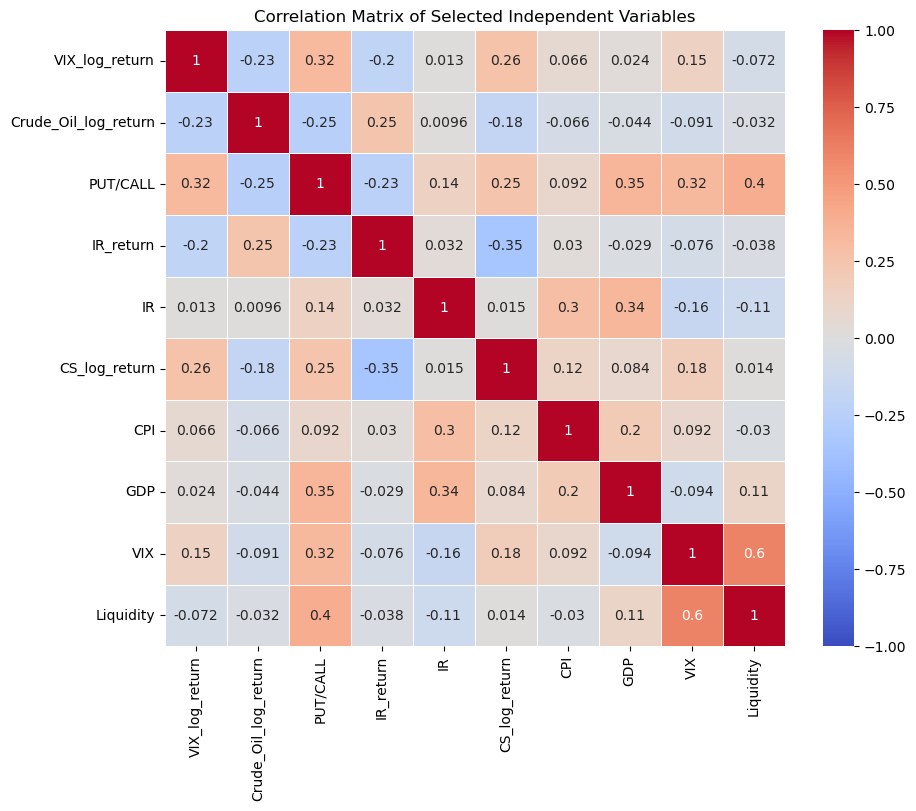

In [9]:
# Compute the correlation matrix
corr_matrix = X_train.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, linewidths=0.5)

# Set the title for the heatmap
plt.title('Correlation Matrix of Selected Independent Variables')
plt.savefig('images/corr_selected_var.png', dpi=300)
# Show the plot
plt.show()

# Markov regime switching model

In [10]:
# Define and fit the Markov Regime-Switching model
msm_model = sm.tsa.MarkovRegression(y_train, k_regimes=2, exog=X_train, switching_variance=True)
msm_result = msm_model.fit()

# print results
print(msm_result.summary())
table_msm = msm_result.summary()

# Smoothed probabilities of the regimes
regime_probabilities = msm_result.smoothed_marginal_probabilities

                        Markov Switching Model Results                        
Dep. Variable:         MOM_log_return   No. Observations:                 1037
Model:               MarkovRegression   Log Likelihood                -927.607
Date:                Thu, 30 Jan 2025   AIC                           1907.215
Time:                        17:12:24   BIC                           2035.761
Sample:                    01-16-2005   HQIC                          1955.985
                         - 11-24-2024                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5968      0.046     12.884      0.000       0.506       0.688
x1            -0.3794      0.027    -13.978      0.0

## Probability matrix

This probability matrix estimates the probability of classification in a specific regime.

In [11]:
regime_probabilities.to_csv('tables/regime_probabilities.csv', index=False)
print(regime_probabilities)

                       0         1
2005-01-16  1.328635e-01  0.867137
2005-01-23  1.102071e-01  0.889793
2005-01-30  7.720367e-02  0.922796
2005-02-06  4.077188e-02  0.959228
2005-02-13  1.384054e-02  0.986159
...                  ...       ...
2024-10-27  1.798752e-08  1.000000
2024-11-03  5.515240e-08  1.000000
2024-11-10  7.347436e-05  0.999927
2024-11-17  5.900464e-08  1.000000
2024-11-24  3.581367e-04  0.999642

[1037 rows x 2 columns]


## Performances Summary

Take the stronger signal to choose the regime.

In [12]:
stats, regimes_binary, dynamic = f.calculate_strategy_statistics(data_w, regime_probabilities)

# Print statistics for each strategy
for strategy, metrics in stats.items():
    print(f"Statistics for {strategy}:")
    for metric, value in metrics.items():
        if metric != "Annualized Variance (%)":
            print(f"  {metric}: {value:.2f}")
    print()


Statistics for LOW_VOL_Return:
  Annualized Mean (%): 7.48
  Annualized Std Dev (%): 10.38
  Sharpe Ratio: 0.72

Statistics for MOM_Return:
  Annualized Mean (%): 11.12
  Annualized Std Dev (%): 14.35
  Sharpe Ratio: 0.77

Statistics for MSCI_Return:
  Annualized Mean (%): 8.75
  Annualized Std Dev (%): 14.13
  Sharpe Ratio: 0.62

Statistics for Regime Switching Strategy:
  Annualized Mean (%): 11.11
  Annualized Std Dev (%): 10.70
  Sharpe Ratio: 1.04



## Switch Statistics

In [13]:
N_time_MOM, N_time_LOW_VOL, switch_count, start_date, end_date, switch_df = f.analyze_regime_switches(regimes_binary)

print(f'The model allows {N_time_MOM} weeks to the Momentum portfolio.')
print(f'The model allows {N_time_LOW_VOL} weeks to the Minimum Volatility  portfolio.')
if switch_df.empty:
    print(f'There were no switches made during the period between {start_date} and {end_date}.')
else:
    print(f'The model does {switch_count} switches during the period between {start_date} and {end_date}.')

The model allows 298 weeks to the Momentum portfolio.
The model allows 739 weeks to the Minimum Volatility  portfolio.
The model does 28 switches during the period between 2005-01-16 and 2024-11-24.


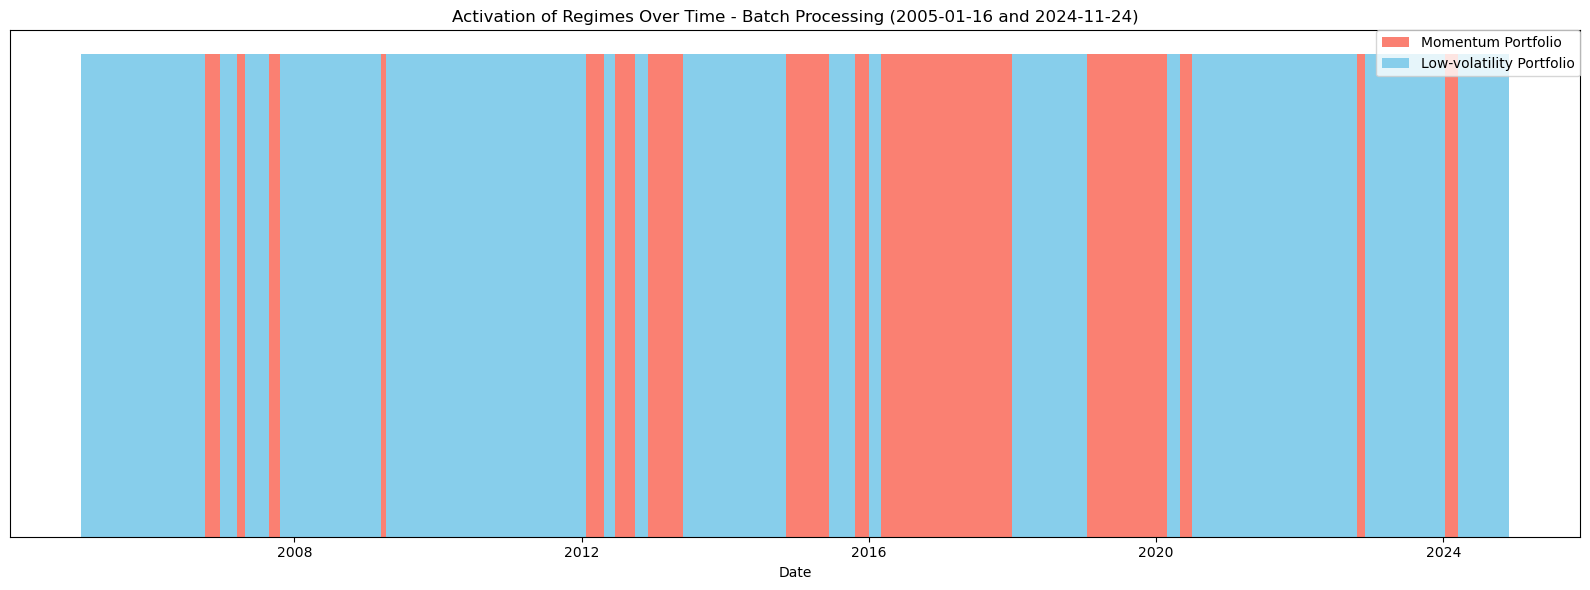

In [14]:
f.plot_regime_activation(regimes_binary,"Activation of Regimes Over Time - Batch Processing (2005-01-16 and 2024-11-24)")

# Model Enhancement

This section try to improve the model with a rolling window, an exopanding window and a neutral switching zone.
Finally, only the expanding window is keeped for the final model.

## Rolling Windows

In [15]:
results_r = f.calculate_rolling_window_regime_probabilities(y, X, window_size=259, k_regimes=2)

C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Window
Statistics for LOW_VOL_Return:
  Annualized Mean (%): 7.59
  Annualized Std Dev (%): 10.37
  Sharpe Ratio: 0.73

Statistics for MOM_Return:
  Annualized Mean (%): 11.27
  Annualized Std Dev (%): 14.34
  Sharpe Ratio: 0.79

Statistics for MSCI_Return:
  Annualized Mean (%): 8.86
  Annualized Std Dev (%): 14.13
  Sharpe Ratio: 0.63

Statistics for Regime Switching Strategy:
  Annualized Mean (%): 8.12
  Annualized Std Dev (%): 10.39
  Sharpe Ratio: 0.78



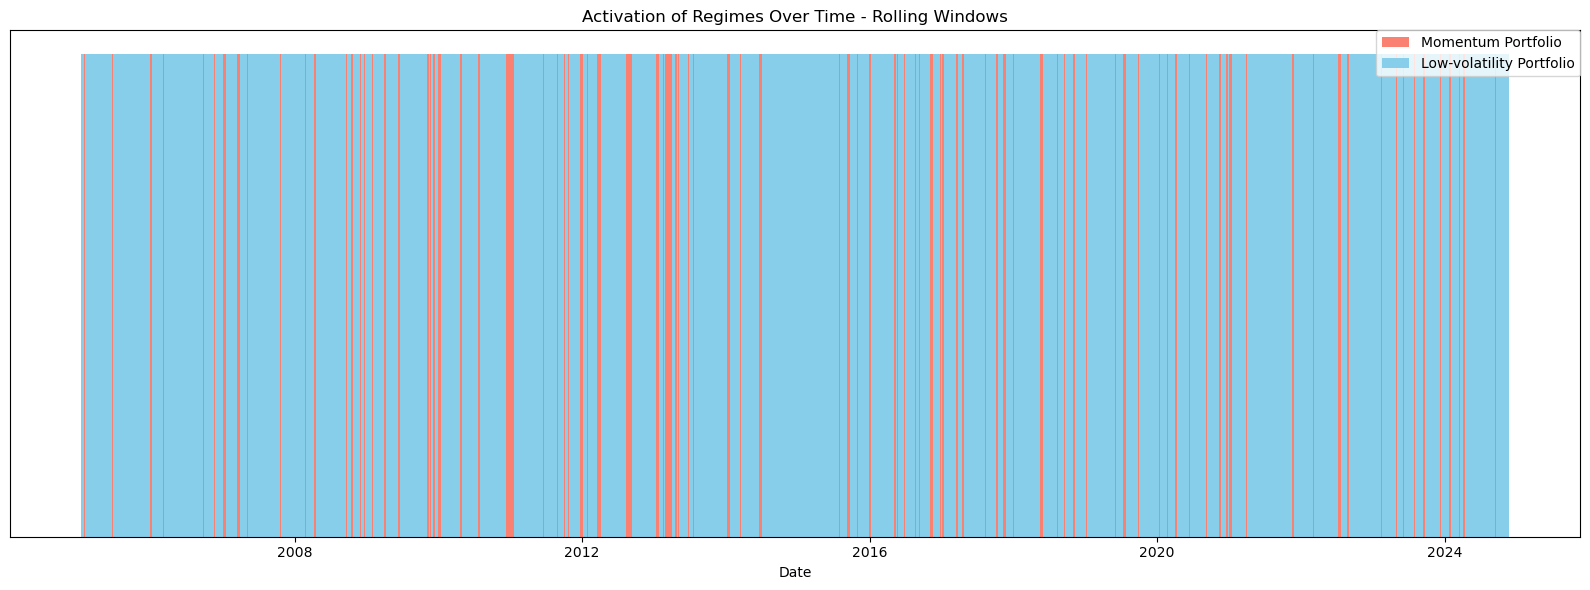

All Dataset
Statistics for LOW_VOL_Return:
  Annualized Mean (%): 7.60
  Annualized Std Dev (%): 10.38
  Sharpe Ratio: 0.73

Statistics for MOM_Return:
  Annualized Mean (%): 11.25
  Annualized Std Dev (%): 14.35
  Sharpe Ratio: 0.78

Statistics for MSCI_Return:
  Annualized Mean (%): 8.88
  Annualized Std Dev (%): 14.14
  Sharpe Ratio: 0.63

Statistics for Regime Switching Strategy:
  Annualized Mean (%): 11.12
  Annualized Std Dev (%): 10.71
  Sharpe Ratio: 1.04



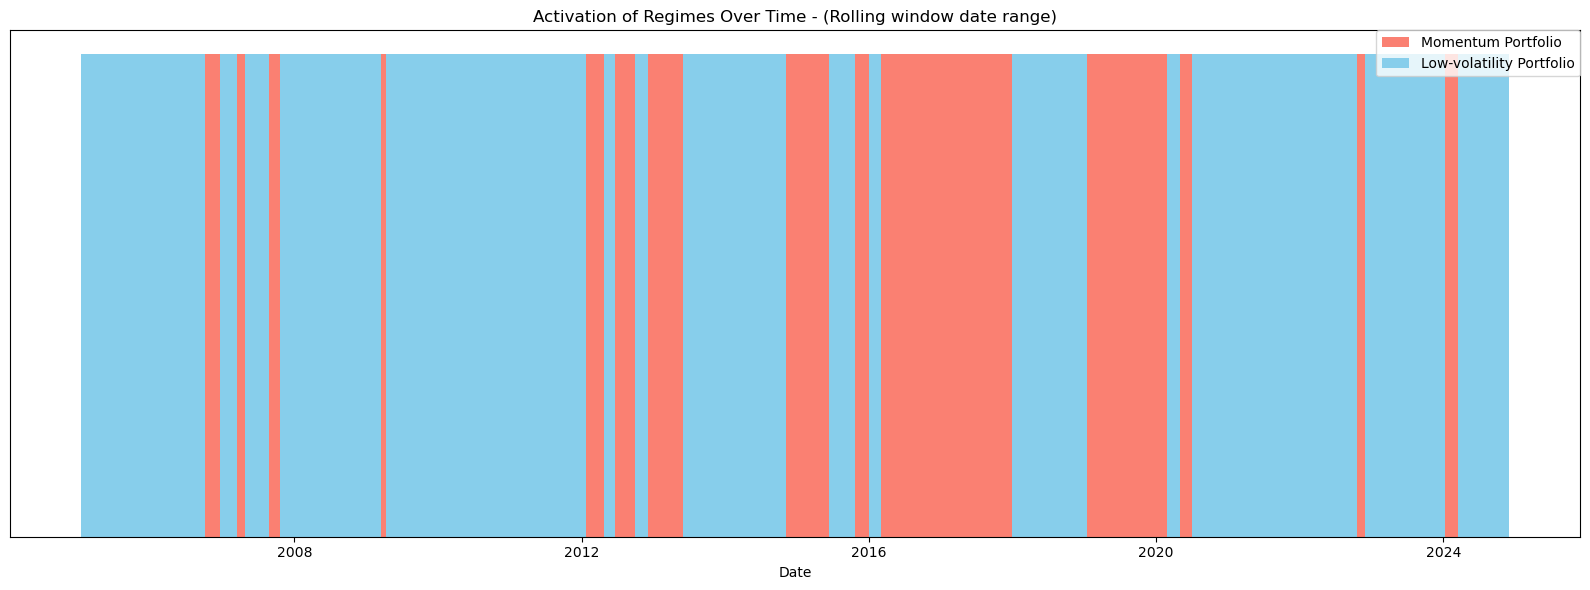

In [16]:
BOLD = "\033[1m"
RESET = "\033[0m"
rolling_probs = results_r['Rolling_Probabilities']
rolling_probs_binary = rolling_probs.round(0)
rolling_probs.rename(columns={'Regime 0': 0}, inplace=True)
rolling_probs.rename(columns={'Regime 1': 1}, inplace=True)

# Print text in bold
print(f"{BOLD}Rolling Window{RESET}")
stats_rolling, rolling_regime, dynamic_rolling = f.calculate_strategy_statistics(data_w, rolling_probs)
# Print statistics for each strategy
for strategy, metrics in stats_rolling.items():
    print(f"Statistics for {strategy}:")
    for metric, value in metrics.items():
        if metric != "Annualized Variance (%)":
            print(f"  {metric}: {value:.2f}")
    print()

f.plot_regime_activation(rolling_regime,"Activation of Regimes Over Time - Rolling Windows")

print(f"{BOLD}All Dataset{RESET}")
stats_general, general_regime, dynamic = f.calculate_strategy_statistics(data_w, regime_probabilities)
# Print statistics for each strategy
for strategy, metrics in stats_general.items():
    print(f"Statistics for {strategy}:")
    for metric, value in metrics.items():
        if metric != "Annualized Variance (%)":
            print(f"  {metric}: {value:.2f}")
    print()

f.plot_regime_activation(regimes_binary,"Activation of Regimes Over Time - (Rolling window date range)")

In [17]:
# Find the intersection of the two indices
g = general_regime[['Regime 0','Regime 1']]
e = rolling_regime[['Regime 0','Regime 1']]

common_indices = g.index.intersection(e.index)

# Reindex both DataFrames to only include these common indices
aligned_general = g.loc[common_indices]
aligned_rolling = e.loc[common_indices]

# Get the regime with the highest probability for both models
general_regimes = aligned_general.idxmax(axis=1)  # Regime with highest probability in the general model
rolling_regimes = aligned_rolling.idxmax(axis=1)  # Regime with highest probability in the rolling model

# Compare the two regimes and calculate the number of times they are the same
same_regime_count = (general_regimes == rolling_regimes).sum()

# Print the result
print(f"The general model and rolling window model assigned the same regime {same_regime_count} times on {len(general_regimes)}, for a precision of {same_regime_count/len(general_regimes)}.")

The general model and rolling window model assigned the same regime 710 times on 1036, for a precision of 0.6853281853281853.


## Expanding Windows

In [18]:
initial_data_size=317
results_e = f.calculate_expanding_window_regime_probabilities(y, X, k_regimes=2,increment_size=10, initial_data_size=317)

C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 317 took 7.5921 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 327 took 6.5613 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 337 took 6.6041 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 347 took 7.5901 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 357 took 7.0904 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 367 took 8.2957 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 377 took 7.9914 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 387 took 8.1385 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 397 took 7.7434 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 407 took 8.3251 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 417 took 8.0462 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 427 took 8.6019 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 437 took 9.5382 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 447 took 9.2353 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 457 took 9.8129 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 467 took 8.9907 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 477 took 9.6209 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 487 took 12.3393 seconds
Iteration for window ending at 497 took 9.9939 seconds
Iteration for window ending at 507 took 11.1688 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 517 took 18.7829 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 527 took 16.4560 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 537 took 12.9948 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 547 took 12.0083 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 557 took 12.4905 seconds
Iteration for window ending at 567 took 9.9780 seconds
Iteration for window ending at 577 took 9.3202 seconds
Iteration for window ending at 587 took 9.4485 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 597 took 11.6463 seconds
Iteration for window ending at 607 took 10.2338 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 617 took 12.4213 seconds
Iteration for window ending at 627 took 11.3839 seconds
Iteration for window ending at 637 took 13.1662 seconds
Iteration for window ending at 647 took 11.5908 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 657 took 12.2733 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 667 took 12.4349 seconds
Iteration for window ending at 677 took 12.5083 seconds
Iteration for window ending at 687 took 11.9337 seconds
Iteration for window ending at 697 took 12.4745 seconds
Iteration for window ending at 707 took 12.0669 seconds
Iteration for window ending at 717 took 12.6750 seconds
Iteration for window ending at 727 took 14.1673 seconds
Iteration for window ending at 737 took 16.8966 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 747 took 19.4830 seconds
Iteration for window ending at 757 took 22.6280 seconds
Iteration for window ending at 767 took 13.9955 seconds
Iteration for window ending at 777 took 11.8519 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 787 took 13.9948 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 797 took 15.3578 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 807 took 15.3014 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 817 took 14.6549 seconds
Iteration for window ending at 827 took 13.9907 seconds
Iteration for window ending at 837 took 12.1922 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 847 took 17.4009 seconds
Iteration for window ending at 857 took 13.8776 seconds
Iteration for window ending at 867 took 12.2015 seconds
Iteration for window ending at 877 took 13.3441 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 887 took 16.0824 seconds
Iteration for window ending at 897 took 16.1824 seconds
Iteration for window ending at 907 took 12.7863 seconds
Iteration for window ending at 917 took 12.5973 seconds
Iteration for window ending at 927 took 13.9290 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 937 took 22.3326 seconds
Iteration for window ending at 947 took 25.8912 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 957 took 22.5637 seconds
Iteration for window ending at 967 took 14.7741 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 977 took 16.9374 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 987 took 19.5871 seconds
Iteration for window ending at 997 took 16.1439 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 1007 took 19.1665 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 1017 took 18.5137 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 1027 took 18.8265 seconds


C:\Users\u1b651\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration for window ending at 1037 took 19.3426 seconds


Expanding Window
Statistics for LOW_VOL_Return:
  Annualized Mean (%): 7.62
  Annualized Std Dev (%): 10.38
  Sharpe Ratio: 0.73

Statistics for MOM_Return:
  Annualized Mean (%): 11.26
  Annualized Std Dev (%): 14.35
  Sharpe Ratio: 0.78

Statistics for MSCI_Return:
  Annualized Mean (%): 8.91
  Annualized Std Dev (%): 14.15
  Sharpe Ratio: 0.63

Statistics for Regime Switching Strategy:
  Annualized Mean (%): 8.66
  Annualized Std Dev (%): 8.20
  Sharpe Ratio: 1.06



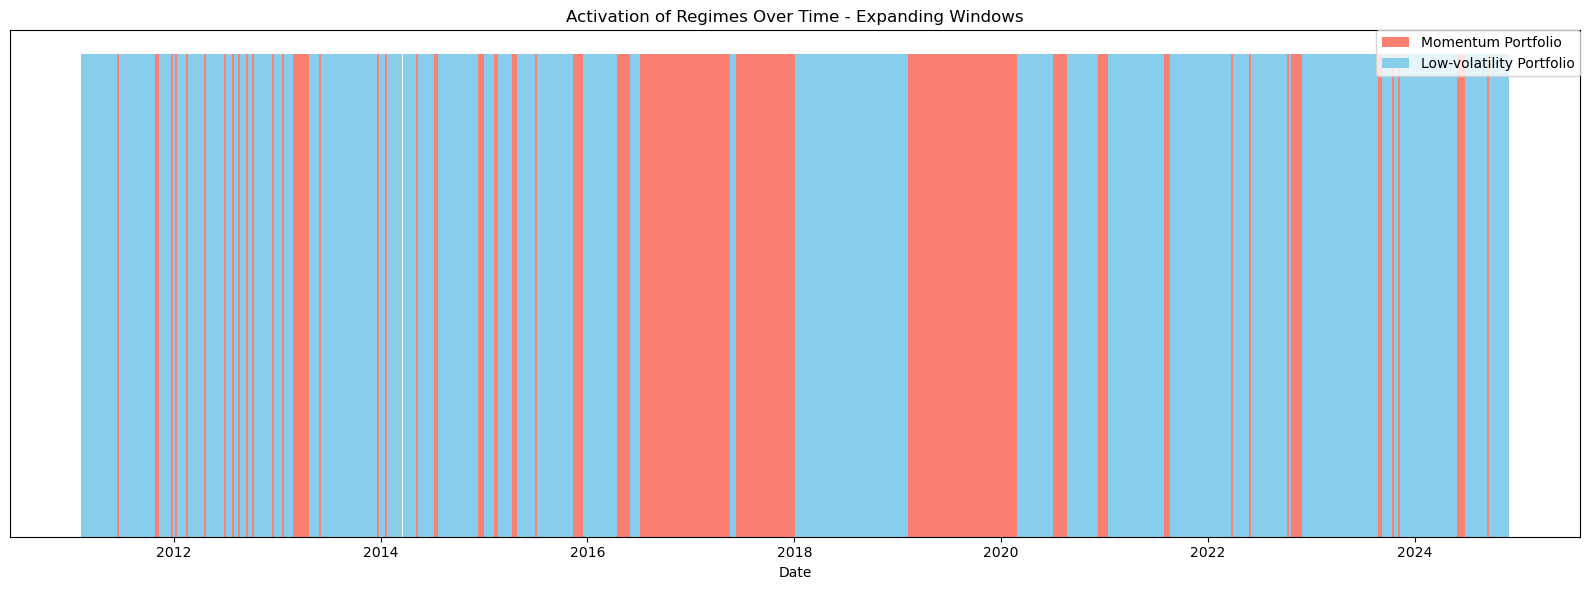

All Dataset
Statistics for LOW_VOL_Return:
  Annualized Mean (%): 7.64
  Annualized Std Dev (%): 10.39
  Sharpe Ratio: 0.74

Statistics for MOM_Return:
  Annualized Mean (%): 11.27
  Annualized Std Dev (%): 14.36
  Sharpe Ratio: 0.78

Statistics for MSCI_Return:
  Annualized Mean (%): 8.93
  Annualized Std Dev (%): 14.15
  Sharpe Ratio: 0.63

Statistics for Regime Switching Strategy:
  Annualized Mean (%): 11.17
  Annualized Std Dev (%): 10.72
  Sharpe Ratio: 1.04



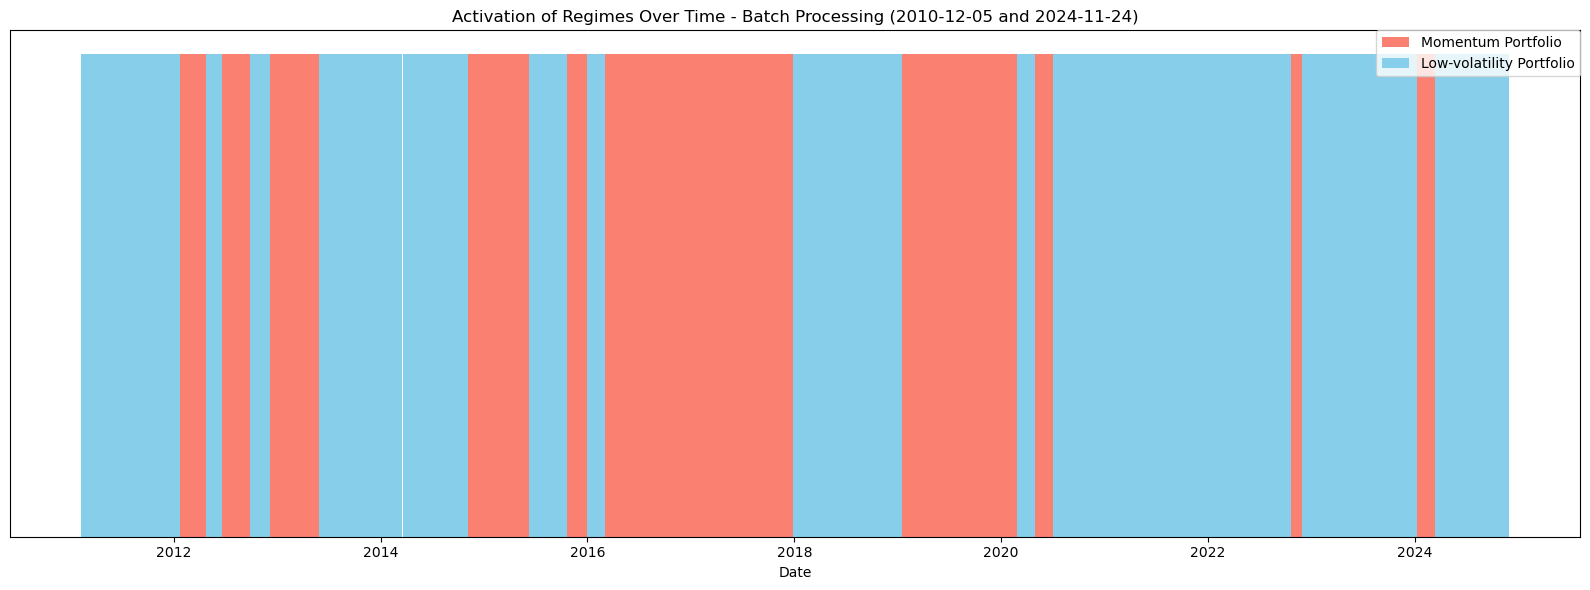

In [19]:
BOLD = "\033[1m"
RESET = "\033[0m"
expanding_probs = results_e['Expanding_Window_Probabilities']
expanding_probs_binary = expanding_probs.round(0)
expanding_probs.rename(columns={'Regime 0': 0}, inplace=True)
expanding_probs.rename(columns={'Regime 1': 1}, inplace=True)

# Print text in bold
print(f"{BOLD}Expanding Window{RESET}")
stats_expanding, expanding_regime, dynamic_expanding = f.calculate_strategy_statistics(data_w, expanding_probs)
# Print statistics for each strategy
for strategy, metrics in stats_expanding.items():
    print(f"Statistics for {strategy}:")
    for metric, value in metrics.items():
        if metric != "Annualized Variance (%)":
            print(f"  {metric}: {value:.2f}")
    print()

f.plot_regime_activation(expanding_regime.iloc[initial_data_size:],"Activation of Regimes Over Time - Expanding Windows")

print(f"{BOLD}All Dataset{RESET}")
stats_general, general_regime, dynamic = f.calculate_strategy_statistics(data_w, regime_probabilities)
# Print statistics for each strategy
for strategy, metrics in stats_general.items():
    print(f"Statistics for {strategy}:")
    for metric, value in metrics.items():
        if metric != "Annualized Variance (%)":
            print(f"  {metric}: {value:.2f}")
    print()

f.plot_regime_activation(regimes_binary.iloc[initial_data_size:],"Activation of Regimes Over Time - Batch Processing (2010-12-05 and 2024-11-24)")

Number of same Regime

In [20]:
# Find the intersection of the two indices
g = general_regime[['Regime 0','Regime 1']].iloc[initial_data_size:]
e = expanding_regime[['Regime 0','Regime 1']].iloc[initial_data_size:]

common_indices = g.index.intersection(e.index)

# Reindex both DataFrames to only include these common indices
aligned_general = g.loc[common_indices]
aligned_expanding = e.loc[common_indices]

# Get the regime with the highest probability for both models
general_regimes = aligned_general.idxmax(axis=1)  # Regime with highest probability in the general model
expanding_regimes = aligned_expanding.idxmax(axis=1)  # Regime with highest probability in the expanding model

# Compare the two regimes and calculate the number of times they are the same
same_regime_count = (general_regimes == expanding_regimes).sum()

# Print the result
print(f"The general model and expanding window model assigned the same regime {same_regime_count} times on {len(general_regimes)}, for a precision of {same_regime_count/len(general_regimes)}.")

The general model and expanding window model assigned the same regime 580 times on 720, for a precision of 0.8055555555555556.


Number of switch

In [21]:
N_time_MOM, N_time_LOW_VOL, switch_count, start_date, end_date, switch_df = f.analyze_regime_switches(e)

print(f'The model allows {N_time_MOM} weeks to the momentum portfolio.')
print(f'The model allows {N_time_LOW_VOL} weeks to the Minimum Volatility  portfolio.')
if switch_df.empty:
    print(f'There were no switches made during the period between {start_date} and {end_date}.')
else:
    print(f'The model does {switch_count} switches during the period between {start_date} and {end_date}.')

The model allows 212 weeks to the momentum portfolio.
The model allows 508 weeks to the Minimum Volatility  portfolio.
The model does 80 switches during the period between 2011-02-13 and 2024-11-24.


## Neutral switch zone

Introduction of a neutral zone to understand if the model switch to light signals. The neutral zone are represented in white on he next graph


Statistics for LOW_VOL_Return:
  Annualized Return: 7.57
  Annualized Variance: 107.93
  Annualized Std Dev: 10.39
  Sharpe Ratio: 0.73

Statistics for MOM_Return:
  Annualized Return: 11.15
  Annualized Variance: 206.14
  Annualized Std Dev: 14.36
  Sharpe Ratio: 0.78

Statistics for MSCI_Return:
  Annualized Return: 8.86
  Annualized Variance: 200.38
  Annualized Std Dev: 14.16
  Sharpe Ratio: 0.63

Statistics for Regime Switching Strategy:
  Annualized Return: 5.87
  Annualized Variance: 57.31
  Annualized Std Dev: 7.57
  Sharpe Ratio: 0.78



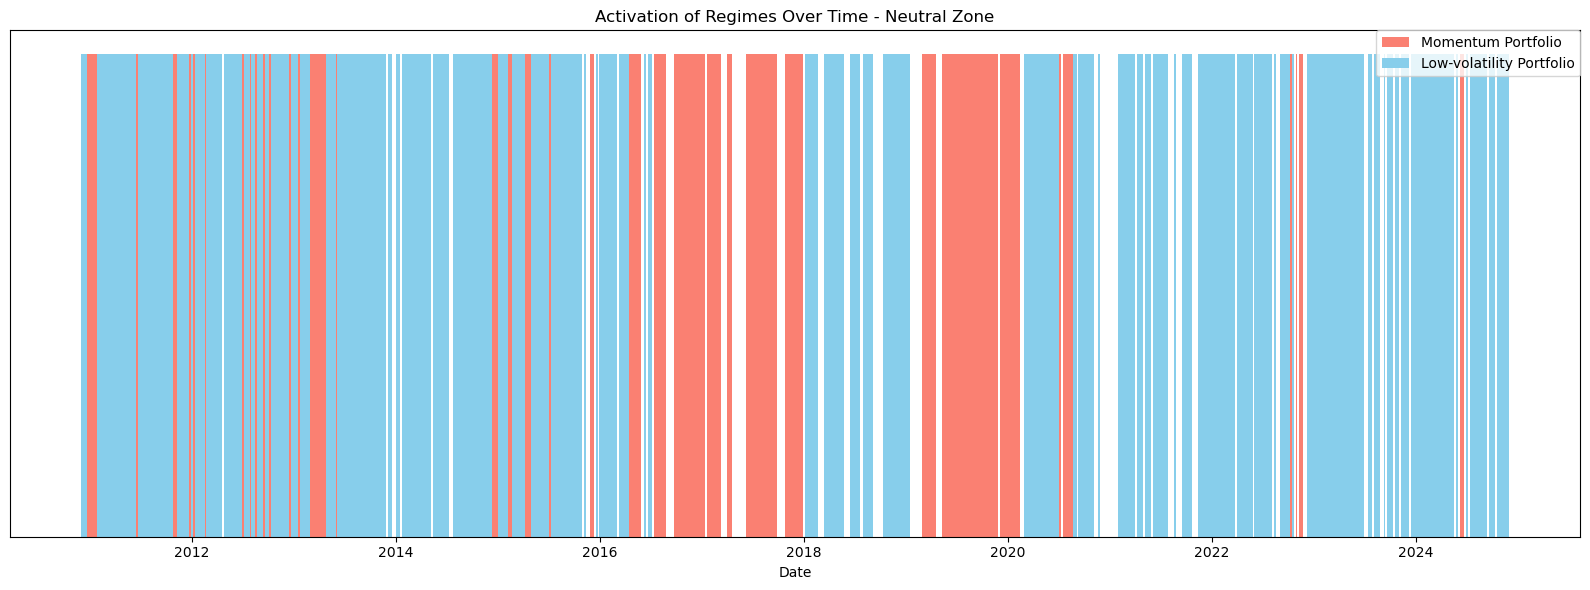

In [22]:
stats_neutral, regimes_neutral, dynamic_neutral = f.neutral_zone_no_fill(data_w, expanding_probs)

# Print statistics for each strategy
for strategy, metrics in stats_neutral.items():
    print(f"Statistics for {strategy}:")
    for metric, value in metrics.items():
        if metric != "Annualized Variance (%)":
            print(f"  {metric}: {value:.2f}")
    print()


f.plot_regime_activation(regimes_neutral,"Activation of Regimes Over Time - Neutral Zone")

## Fill with previous value

Simulate a forward-fill of the neutral zone, the strategy does not improve the model, so it is discarded.

Statistics for LOW_VOL_Return:
  Annualized Return: 7.55
  Annualized Variance: 108.03
  Annualized Std Dev: 10.39
  Sharpe Ratio: 0.73

Statistics for MOM_Return:
  Annualized Return: 11.10
  Annualized Variance: 206.30
  Annualized Std Dev: 14.36
  Sharpe Ratio: 0.77

Statistics for MSCI_Return:
  Annualized Return: 8.84
  Annualized Variance: 200.57
  Annualized Std Dev: 14.16
  Sharpe Ratio: 0.62

Statistics for Regime Switching Strategy:
  Annualized Return: 7.56
  Annualized Variance: 66.30
  Annualized Std Dev: 8.14
  Sharpe Ratio: 0.93



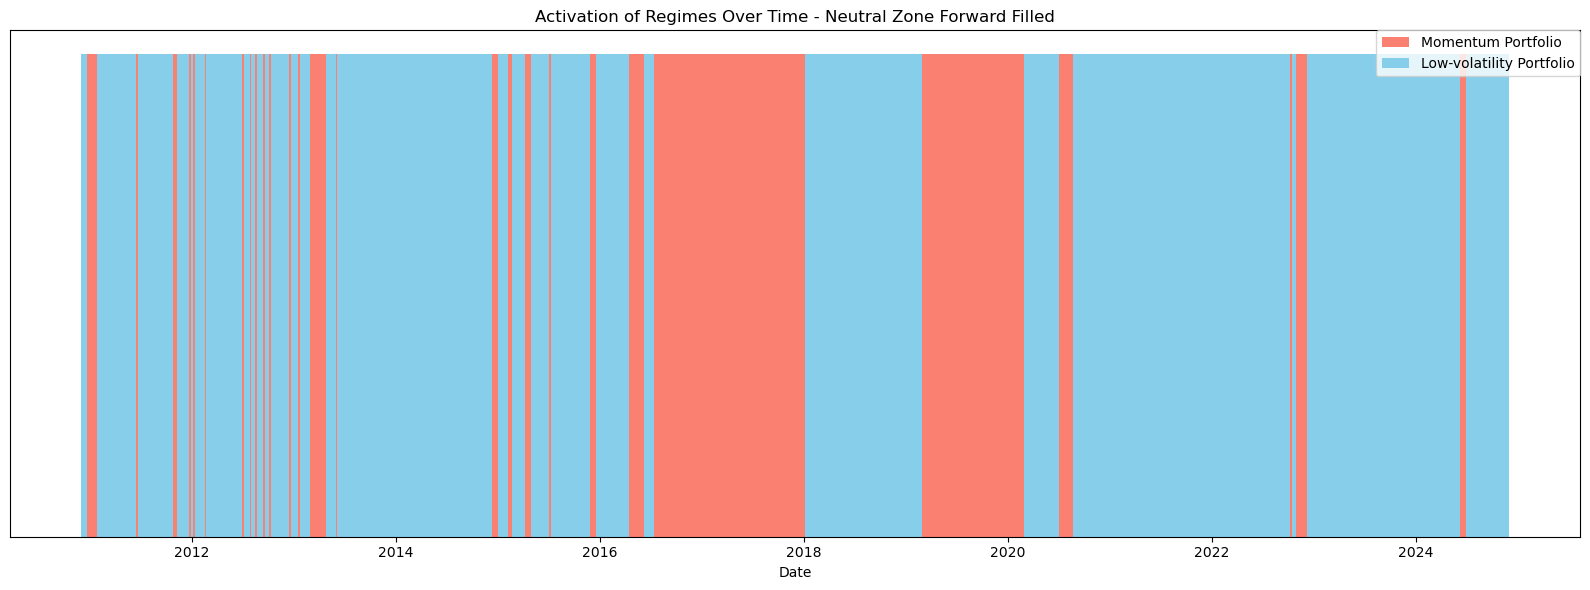

In [23]:
stats_fill, regimes_fill, dynamic_fill = f.calculate_strategy_statistics_neutral_zone(data_w, expanding_probs)

# Print statistics for each strategy
for strategy, metrics in stats_fill.items():
    print(f"Statistics for {strategy}:")
    for metric, value in metrics.items():
        if metric != "Annualized Variance (%)":
            print(f"  {metric}: {value:.2f}")
    print()
    
f.plot_regime_activation(regimes_fill, "Activation of Regimes Over Time - Neutral Zone Forward Filled")

In [24]:
print(stats_expanding)

{'LOW_VOL_Return': {'Annualized Mean (%)': 7.623233557400215, 'Annualized Variance (%)': 107.83388437376561, 'Annualized Std Dev (%)': 10.384309528021863, 'Sharpe Ratio': 0.7341107790391902}, 'MOM_Return': {'Annualized Mean (%)': 11.263979704762484, 'Annualized Variance (%)': 206.05894642480257, 'Annualized Std Dev (%)': 14.35475344353927, 'Sharpe Ratio': 0.7846863931913878}, 'MSCI_Return': {'Annualized Mean (%)': 8.914823314300847, 'Annualized Variance (%)': 200.11224134868877, 'Annualized Std Dev (%)': 14.146103398062973, 'Sharpe Ratio': 0.6301963914332448}, 'Regime Switching Strategy': {'Annualized Mean (%)': 8.663912871157132, 'Annualized Variance (%)': 67.25607646229071, 'Annualized Std Dev (%)': 8.200980213504401, 'Sharpe Ratio': 1.0564484544043198}}


# Final Dataset

Create Final Dataset Metrics

In [25]:
dynamic_final = pd.DataFrame(dynamic_expanding)
regime_final = pd.DataFrame(expanding_regime)

# Results

## Return, Std, & Sharpe Ratio comparison

This part gives a general summary of the main statistics of the regime switching strategy and other static allocation strategies

In [26]:
def stats_df(stats_name):
    globals_dict = globals()
    
    if stats_name not in globals_dict:
        raise ValueError("Error: {} is not defined".format(stats_name))
        
    data = globals_dict[stats_name]
    
    df = pd.DataFrame(data)
    
    return df
stats_final = stats_df('stats_expanding')
stats_final.to_csv('tables/stats_final.csv', index=False)
stats_final.head()

,LOW_VOL_Return,MOM_Return,MSCI_Return,Regime Switching Strategy
Annualized Mean (%),7.623234,11.263980,8.914823,8.663913
Annualized Variance (%),107.833884,206.058946,200.112241,67.256076
Annualized Std Dev (%),10.384310,14.354753,14.146103,8.200980
Sharpe Ratio,0.734111,0.784686,0.630196,1.056448


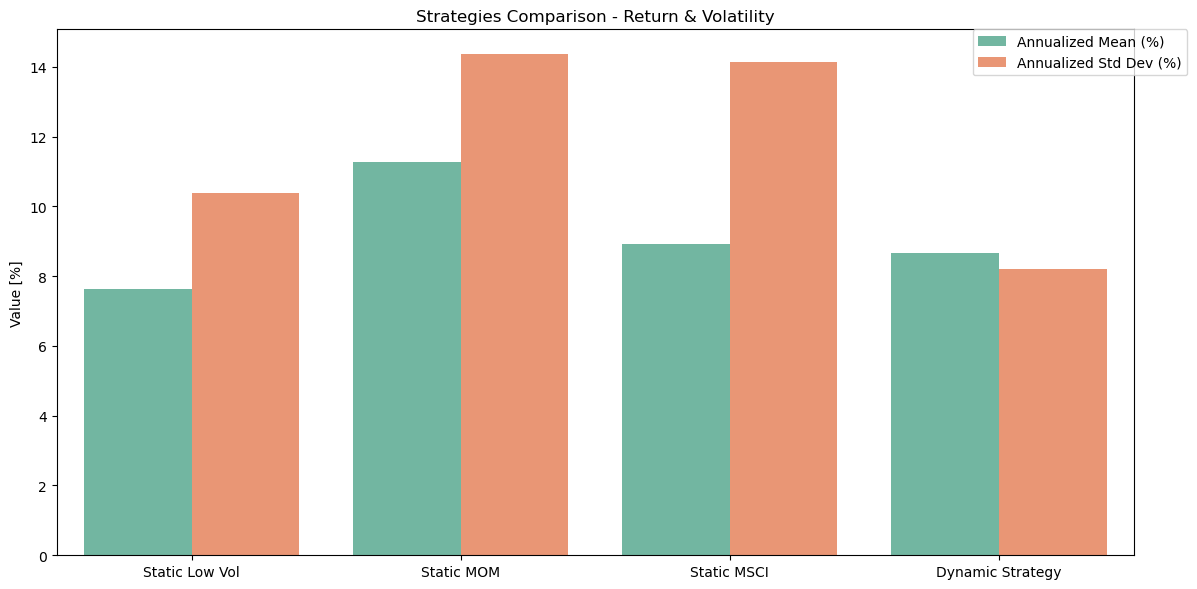

In [27]:
# Create a new DataFrame with the desired format
df = pd.melt(stats_final.reset_index(), id_vars=['index'], var_name='Strategy', value_name='Value')
df['Metric'] = df['index']

# Map strategy names to match the original code
strategy_map = {'LOW_VOL_Return': 'Static Low Vol', 'MOM_Return': 'Static MOM', 'MSCI_Return': 'Static MSCI', 'Regime Switching Strategy': 'Dynamic Strategy'}

# Filter out Sharpe Ratio and Variance, and map strategies at the same time
df_non_sharpe_variance = df[(df['Metric'] != 'Sharpe Ratio') & (df['Metric'] != 'Annualized Variance (%)')].copy().assign(Strategy=lambda x: x['Strategy'].map(strategy_map))

# Plot the non-Sharpe Ratio and Variance metrics
palette = sns.color_palette("Set2")[:len(df_non_sharpe_variance['Metric'].unique())]
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x="Strategy", y="Value", hue="Metric", data=df_non_sharpe_variance, palette=palette, ax=ax)
ax.set_title("Strategies Comparison - Return & Volatility")
ax.set_xlabel("")
ax.set_ylabel("Value [%]")
legend_handles, legend_labels = ax.get_legend_handles_labels()
ax.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
fig.tight_layout()
plt.savefig('images/Return_Vol.png', dpi=300)
plt.show()

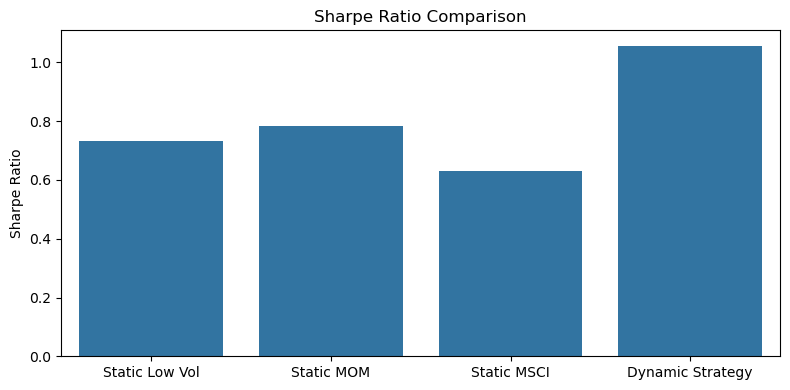

In [28]:
# Filter out non-Sharpe Ratio metrics and map strategies at the same time
df_sharpe = df[df['Metric'] == 'Sharpe Ratio'].copy().assign(Strategy=lambda x: x['Strategy'].map(strategy_map))

# Plot the Sharpe Ratio
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x="Strategy", y="Value", data=df_sharpe, ax=ax)
ax.set_title("Sharpe Ratio Comparison")
ax.set_xlabel("")
ax.set_ylabel("Sharpe Ratio")
fig.tight_layout()
plt.savefig('images/Sharpe_Ratio.png', dpi=300)
plt.show()

## Strategies Plot Cumulated Performances

This section give the cumulated performances of the 4 strategies, in a cumulated product and sum formats.

In [29]:
# First, ensure the index is datetime type if it's not already
dynamic_final.index = pd.to_datetime(dynamic_final.index)

# Find the first non-zero value after the series of zeros
dynamic_final.dropna(inplace=True)
first_non_zero_index = dynamic_final[(dynamic_final[0] != 0)].index[0]
s_date = first_non_zero_index
e_date = dynamic_final.index[-1]
# Slice the DataFrame from the first non-zero value onwards
dynamic_final = dynamic_final.loc[first_non_zero_index:]
data_w= data_w.loc[first_non_zero_index:]
print(first_non_zero_index)
print(dynamic_final)

2010-12-05 00:00:00
                   0
DATE                
2010-12-05  0.002542
2010-12-12  0.008926
2010-12-19  0.010288
2010-12-26  0.007195
2011-01-02  0.000013
...              ...
2024-10-27 -0.014176
2024-11-03 -0.010667
2024-11-10  0.013611
2024-11-17 -0.006755
2024-11-24 -0.000714

[730 rows x 1 columns]


In [30]:
print('Timeframe is from:',s_date.year,'to', e_date.year)

Timeframe is from: 2010 to 2024


In [31]:
def cumulative_product(returns):
    return np.cumprod(1 + returns)-1

cumulative_prod = pd.DataFrame()
cumulative_prod['MSCI World Minimum Volatility '] = cumulative_product(data_w['LOW_VOL_Return'])*100
cumulative_prod['MSCI World Momentum'] = cumulative_product(data_w['MOM_Return'])*100
cumulative_prod['MSCI World'] = cumulative_product(data_w['MSCI_Return'])*100
cumulative_prod['Regime Switching Model'] = cumulative_product(dynamic_final)*100
cumulative_prod.dropna(inplace = True)

cumulative_sum = pd.DataFrame()
cumulative_sum['MSCI World Minimum Volatility '] = data_w['LOW_VOL_Return'].cumsum()*100
cumulative_sum['MSCI World Momentum'] = data_w['MOM_Return'].cumsum()*100
cumulative_sum['MSCI World'] = data_w['MSCI_Return'].cumsum()*100
cumulative_sum['Regime Switching Model'] =dynamic_final.cumsum()*100
cumulative_sum.dropna(inplace = True)

### Cumulative product

In [32]:
cumulative_prod.head(2000)

,MSCI World Minimum Volatility,MSCI World Momentum,MSCI World,Regime Switching Model
DATE,,,,
2010-12-05,0.254160,1.591453,0.867180,0.254160
2010-12-12,1.149048,3.000941,2.900984,1.149048
2010-12-19,2.189696,3.295285,3.683097,2.189696
2010-12-26,2.742361,4.038497,4.586480,2.924953
2011-01-02,3.148282,4.039803,5.114308,2.926245
...,...,...,...,...
2024-10-27,228.454581,438.075295,295.104449,425.997048
2024-11-03,224.951085,431.062155,291.711310,420.386444
2024-11-10,229.373838,440.507965,299.303290,427.469173


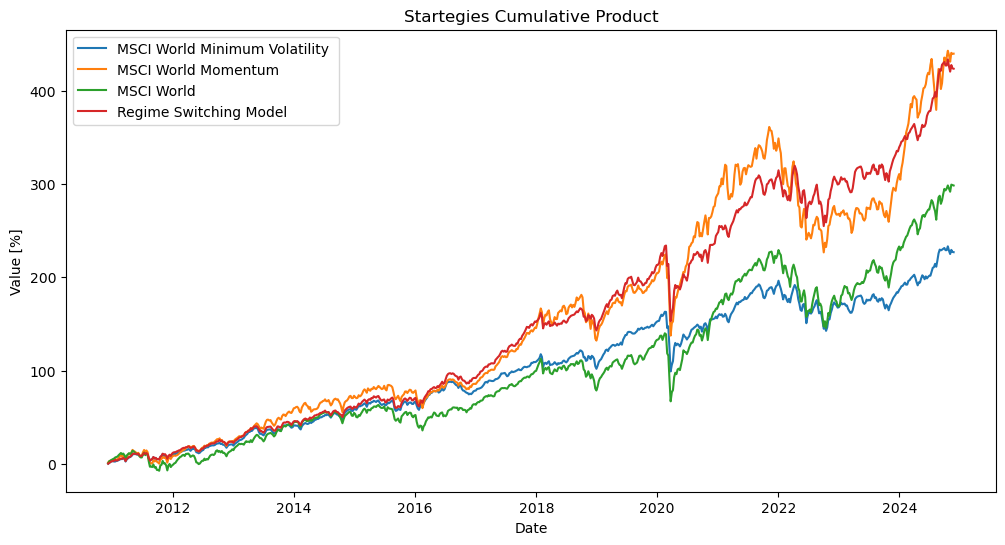

In [33]:
# Columns to plot
columns_to_plot = ['MSCI World Minimum Volatility ', 'MSCI World Momentum', 'MSCI World','Regime Switching Model']

# Create figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))
for col in columns_to_plot:
    ax.plot(cumulative_prod.index, cumulative_prod[col], label=col)
ax.set_title('Startegies Cumulative Product')
ax.set_xlabel('Date')
ax.set_ylabel('Value [%]')
ax.legend(loc='upper left')
plt.savefig('images/cum_prod.png', dpi=300)
plt.show()

### Cumulative sum

In [34]:
cumulative_sum.head(2000)

,MSCI World Minimum Volatility,MSCI World Momentum,MSCI World,Regime Switching Model
DATE,,,,
2010-12-05,0.254160,1.591453,0.867180,0.254160
2010-12-12,1.146780,2.978861,2.883499,1.146780
2010-12-19,2.175606,3.264630,3.643563,2.175606
2010-12-26,2.716428,3.984131,4.514855,2.895107
2011-01-02,3.111514,3.985387,5.019536,2.896363
...,...,...,...,...
2024-10-27,125.134551,180.647540,149.137977,172.897722
2024-11-03,124.067891,179.344165,148.279182,171.831061
2024-11-10,125.428943,181.122829,150.217339,173.192113


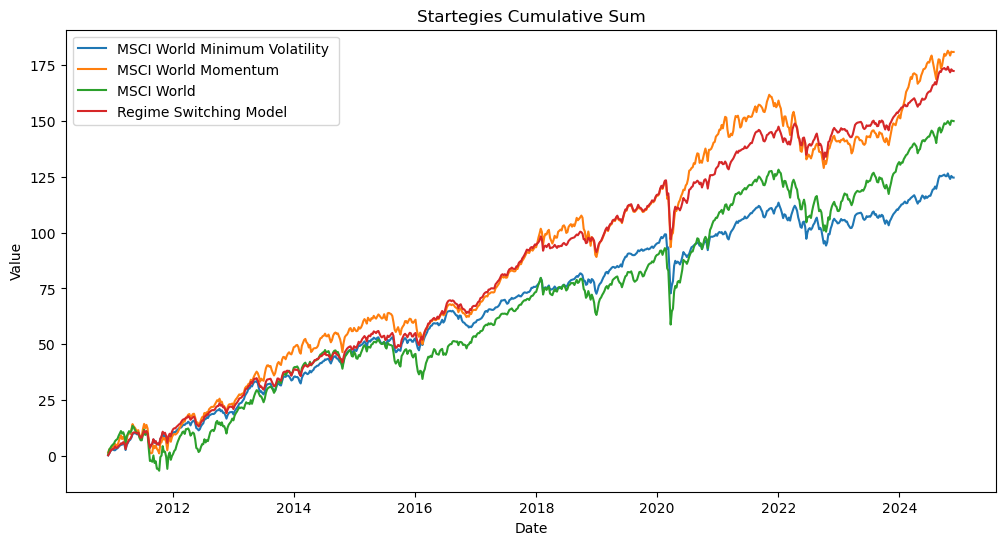

In [35]:
# Columns to plot
columns_to_plot = ['MSCI World Minimum Volatility ', 'MSCI World Momentum', 'MSCI World','Regime Switching Model']

# Create figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))
for col in columns_to_plot:
    ax.plot(cumulative_sum.index, cumulative_sum[col], label=col)
ax.set_title('Startegies Cumulative Sum')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend(loc='upper left')
plt.savefig('images/cum_sum.png', dpi=300)
plt.show()

## Regime Allocation

This section gives the regime allocation of the final case over time, a graph with the cumulated products of the two strategies, as well as a relative performance graph on a 10 week average. Plots of this section are used to assess the significance of the regime allocation.

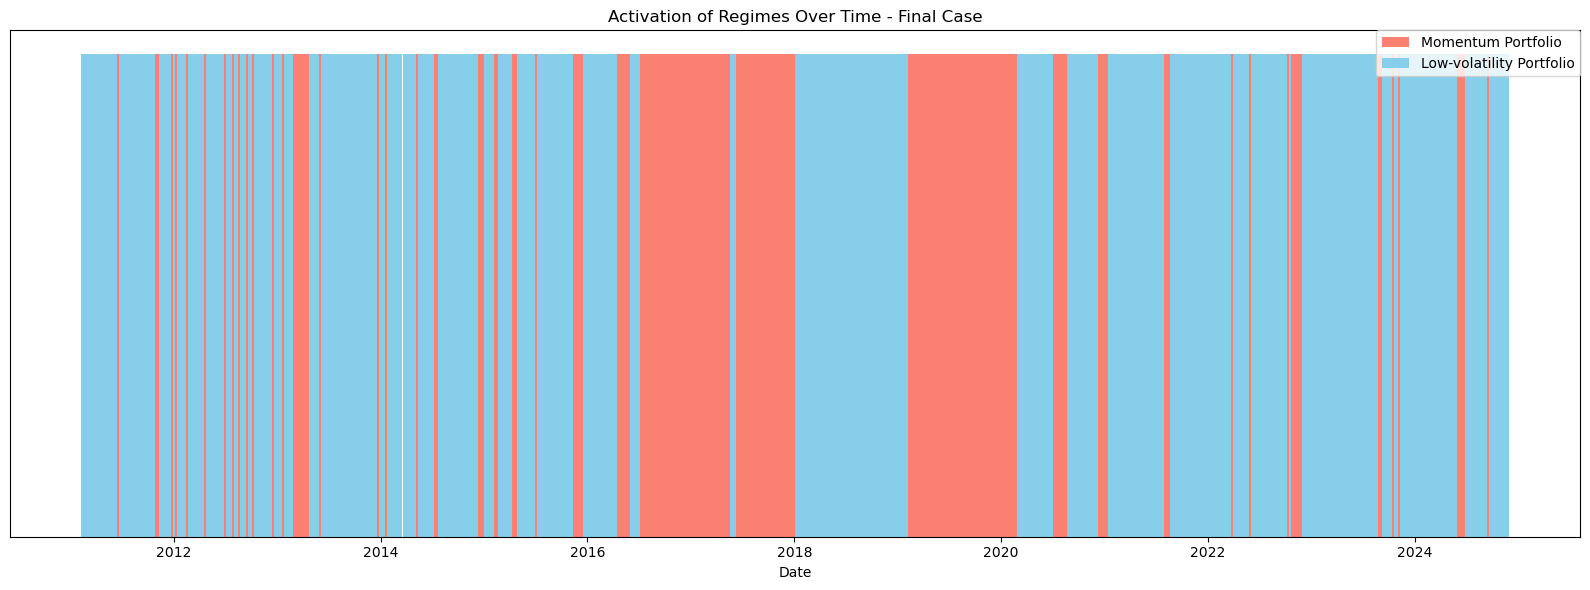

In [36]:
f.plot_regime_activation(expanding_regime.iloc[initial_data_size:],"Activation of Regimes Over Time - Final Case")

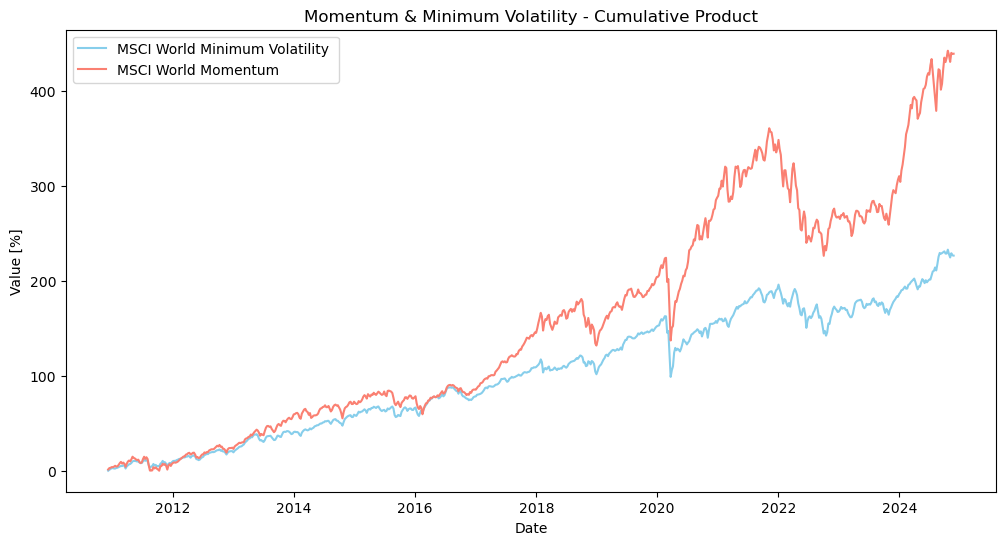

In [37]:
# Columns to plot
columns_to_plot = ['MSCI World Minimum Volatility ', 'MSCI World Momentum']
colors = {'MSCI World Minimum Volatility ': 'skyblue', 'MSCI World Momentum': 'salmon'}

# Create figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))
for col in columns_to_plot:
    ax.plot(cumulative_prod.index, cumulative_prod[col], label=col, color=colors[col])
ax.set_title('Momentum & Minimum Volatility - Cumulative Product')
ax.set_xlabel('Date')
ax.set_ylabel('Value [%]')
ax.legend(loc='upper left')
plt.savefig('images/cum_prod_MOMMV.png', dpi=300)
plt.show()

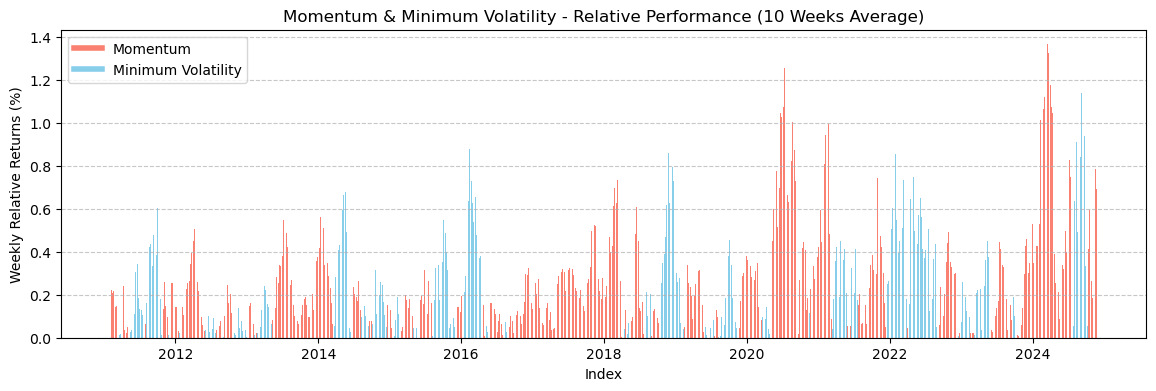

In [38]:
# Assuming data_w is already defined and contains 'MOM_Return' and 'LOW_VOL_Return'
data_w['relative_MV_M'] = (data_w['MOM_Return'] - data_w['LOW_VOL_Return']) * 100

# Calculate the rolling mean over a window of 10 points
data_w['relative_MV_M_rolling'] = data_w['relative_MV_M'].rolling(window=10).mean()

# Drop NaN values resulting from the rolling mean calculation
data_w.dropna(subset=['relative_MV_M_rolling'], inplace=True)

# Reverse negative values
data_w['relative_MV_M_rolling_reversed'] = data_w['relative_MV_M_rolling'].apply(lambda x: -x if x < 0 else x)

# Define colors: salmon for positive, skyblue for negative (original sign)
colors = ['salmon' if x > 0 else 'skyblue' for x in data_w['relative_MV_M_rolling']]

# Plotting
plt.figure(figsize=(14, 4))  # Increased figure size for better visibility
bar_width = 4  # Width of the bars
bars = plt.bar(data_w.index, data_w['relative_MV_M_rolling_reversed'], color=colors, width=bar_width)
plt.title('Momentum & Minimum Volatility - Relative Performance (10 Weeks Average)')
plt.xlabel('Index')
plt.ylabel('Weekly Relative Returns (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Create custom legend
legend_elements = [Line2D([0], [0], color='salmon', lw=4, label='Momentum'),
                   Line2D([0], [0], color='skyblue', lw=4, label='Minimum Volatility')]
plt.legend(handles=legend_elements)

plt.savefig('images/rel_MOMMV.png', dpi=300)
plt.show()


In [39]:
N_time_MOM, N_time_LOW_VOL, switch_count, start_date, end_date, switch_df = f.analyze_regime_switches(expanding_regime)
print(f'Final Model Switch Statistics:')
print(f'The model allows {N_time_MOM} weeks to the Momentum portfolio.')
print(f'The model allows {N_time_LOW_VOL} weeks to the Minimum Volatility  portfolio.')
if switch_df.empty:
    print(f'There were no switches made during the period between {start_date} and {end_date}.')
else:
    print(f'The model does {switch_count} switches during the period between {start_date} and {end_date}.')

Final Model Switch Statistics:
The model allows 217 weeks to the Momentum portfolio.
The model allows 513 weeks to the Minimum Volatility  portfolio.
The model does 82 switches during the period between 2005-01-16 and 2024-11-24.


## Relative Performance

This section brings together the entire composition of relative performances to highlight differences in strategy behavior.

### Calculation

In [40]:
returns = pd.DataFrame()
returns['MSCI'] = data_w['MSCI_Return']
returns['LOW'] = data_w['LOW_VOL_Return']
returns['MOM'] = data_w['MOM_Return']
returns['Dynamic'] = dynamic_final
returns.fillna(0, inplace=True)
returns.to_csv('tables/returns.csv',index=True)
relatives = pd.DataFrame()
relatives['LOW-MSCI'] = (data_w['LOW_VOL_Return']-data_w['MSCI_Return'])
relatives['MOM-MSCI'] = (data_w['MOM_Return']-data_w['MSCI_Return'])
relatives['Dynamic-MSCI'] = (dynamic_final[0]-data_w['MSCI_Return'])
relatives['LOW-MOM'] = (data_w['MOM_Return']-data_w['LOW_VOL_Return'])
cum_relatives = pd.DataFrame()
cum_relatives['LOW-MSCI'] = relatives['LOW-MSCI'].cumsum()*100
cum_relatives['MOM-MSCI'] = relatives['MOM-MSCI'].cumsum()*100
cum_relatives['Dynamic-MSCI'] = relatives['Dynamic-MSCI'].cumsum()*100
prod_relatives = pd.DataFrame()
prod_relatives['LOW-MSCI'] = cumulative_prod['MSCI World Minimum Volatility '] - cumulative_prod['MSCI World']
prod_relatives['MOM-MSCI'] = cumulative_prod['MSCI World Momentum'] - cumulative_prod['MSCI World']
prod_relatives['Dynamic-MSCI'] = cumulative_prod['Regime Switching Model'] - cumulative_prod['MSCI World']

### Cumulative Product comparison with MSCI

Minimum Volatility 

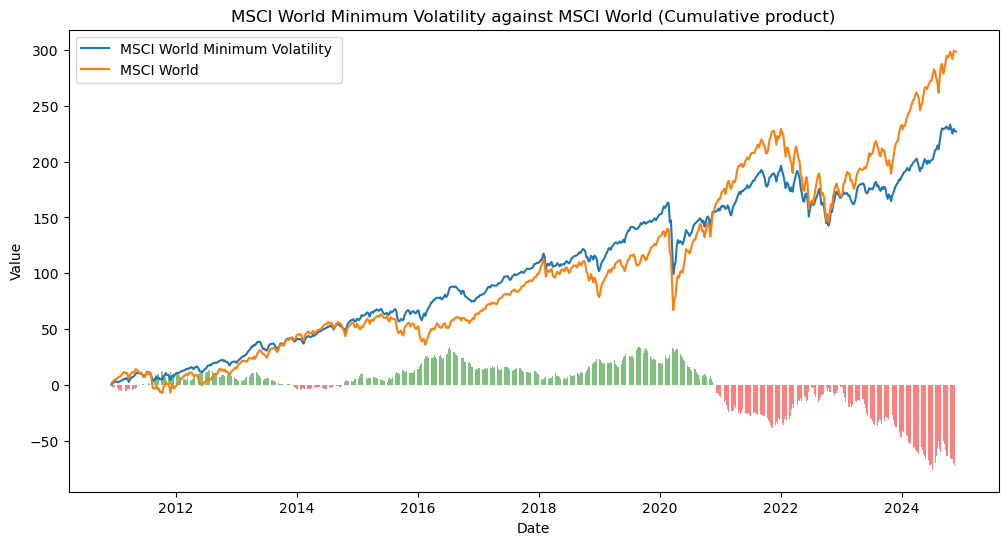

In [41]:
# Select columns to plot
columns_to_plot = ['MSCI World Minimum Volatility ', 'MSCI World']

# Create figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))
for col in columns_to_plot:
    ax.plot(prod_relatives.index, cumulative_prod[col], label=col)
positive_values = prod_relatives['LOW-MSCI'].copy()
negative_values = prod_relatives['LOW-MSCI'].copy()
positive_values[positive_values < 0] = 0
negative_values[negative_values > 0] = 0
ax.bar(prod_relatives.index, positive_values, color='g', alpha=0.5, width=5)
ax.bar(prod_relatives.index, negative_values, color='r', alpha=0.5, width=5)
ax.set_title('MSCI World Minimum Volatility against MSCI World (Cumulative product)')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend(loc='upper left')
plt.show()


Momentum

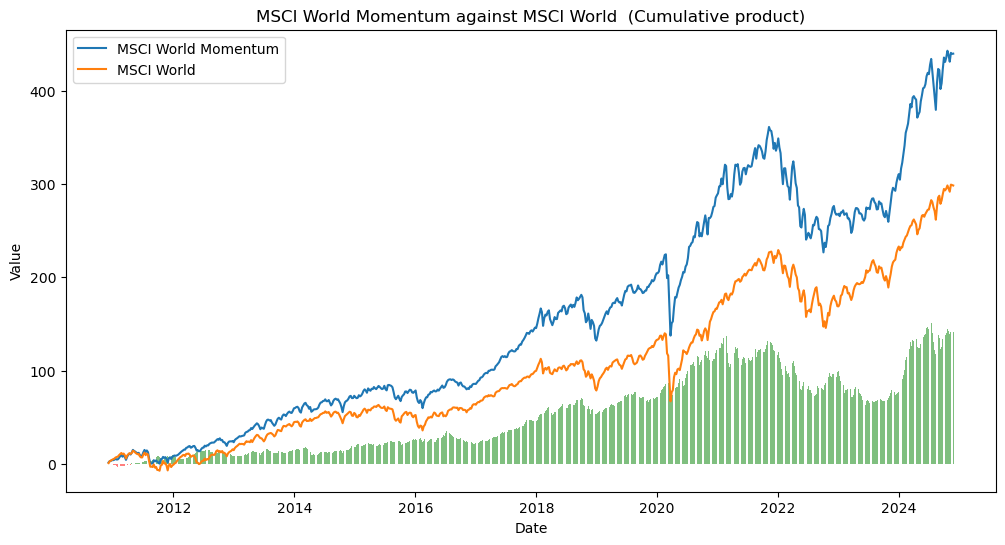

In [42]:
# Select columns to plot
columns_to_plot = ['MSCI World Momentum', 'MSCI World']

# Create figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))
for col in columns_to_plot:
    ax.plot(prod_relatives.index, cumulative_prod[col], label=col)
positive_values = prod_relatives['MOM-MSCI'].copy()
negative_values = prod_relatives['MOM-MSCI'].copy()
positive_values[positive_values < 0] = 0
negative_values[negative_values > 0] = 0
ax.bar(prod_relatives.index, positive_values, color='g', alpha=0.5, width=5)
ax.bar(prod_relatives.index, negative_values, color='r', alpha=0.5, width=5)
ax.set_title('MSCI World Momentum against MSCI World  (Cumulative product)')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend(loc='upper left')
plt.show()


Regime Switching

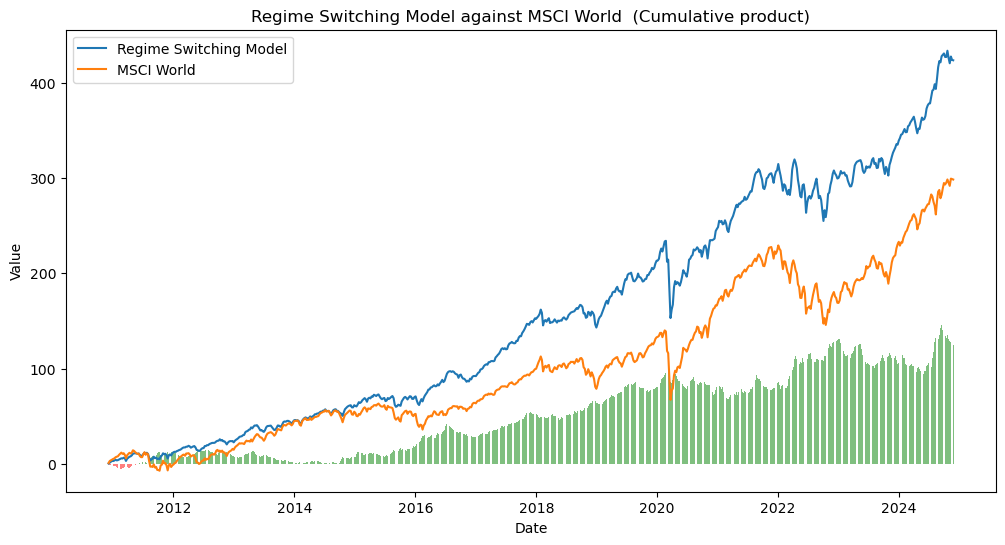

In [43]:
# Select columns to plot
columns_to_plot = ['Regime Switching Model', 'MSCI World']

# Create figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))
for col in columns_to_plot:
    ax.plot(prod_relatives.index, cumulative_prod[col], label=col)
positive_values = prod_relatives['Dynamic-MSCI'].copy()
negative_values = prod_relatives['Dynamic-MSCI'].copy()
positive_values[positive_values < 0] = 0
negative_values[negative_values > 0] = 0
ax.bar(prod_relatives.index, positive_values, color='g', alpha=0.5, width=5)
ax.bar(prod_relatives.index, negative_values, color='r', alpha=0.5, width=5)
ax.set_title('Regime Switching Model against MSCI World  (Cumulative product)')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend(loc='upper left')
plt.show()


## Short Term Analysis

This section simulates an investment horizon of 3 and 5 years with ifferent starting dates. The goal is to assess the short term investment performances of the strategy.

### 3 years

In [44]:
returns.rename(columns={'MSCI': 'MSCI World'}, inplace=True)
returns.rename(columns={'LOW': 'MSCI World Minimum Volatility'}, inplace=True)
returns.rename(columns={'MOM': 'MSCI World Momentum'}, inplace=True)
returns.rename(columns={'Dynamic': 'Regime Switching Model'}, inplace=True)
print(returns)


            MSCI World  MSCI World Minimum Volatility  MSCI World Momentum  \
DATE                                                                         
2011-02-06    0.014087                       0.006123             0.014112   
2011-02-13    0.010547                       0.005285             0.017573   
2011-02-20    0.010941                       0.006815             0.012592   
2011-02-27   -0.011406                      -0.002035            -0.016976   
2011-03-06    0.005941                       0.007940             0.010180   
...                ...                            ...                  ...   
2024-10-27   -0.008321                      -0.014176            -0.008707   
2024-11-03   -0.008588                      -0.010667            -0.013034   
2024-11-10    0.019382                       0.013611             0.017787   
2024-11-17   -0.001292                      -0.006755            -0.002040   
2024-11-24   -0.001027                      -0.000714           

Cumulative Return

C:\Users\u1b651\AppData\Local\Temp\ipykernel_16264\3933430770.py:46: FutureWarning: The provided callable <function sum at 0x00000175E0C7EF20> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivoted_df = results_df.pivot_table(index='Year', columns='Portfolio', values='Cumulative Return', aggfunc=np.sum)


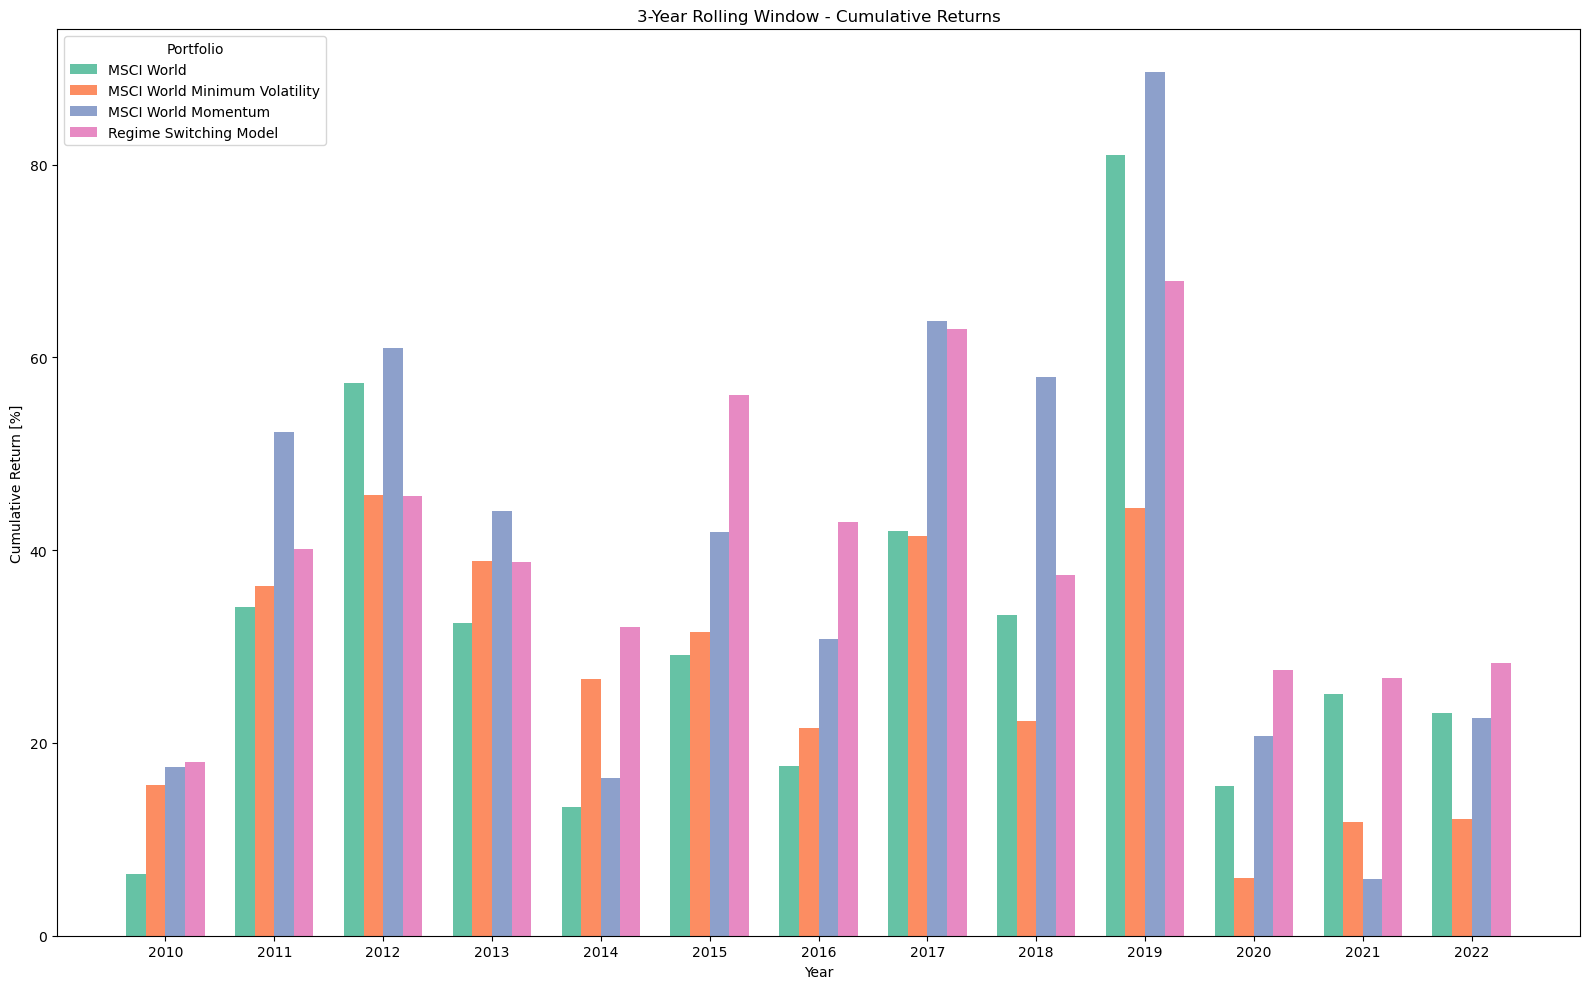

In [45]:
# Define the rolling window size (3 years)
window_size = 3 * 52

results_dict = {
    'Portfolio': [],
    'Year': [],
    'Cumulative Return': []
}

# Define the portfolios to analyze
portfolios = ['MSCI World','MSCI World Minimum Volatility', 'MSCI World Momentum','Regime Switching Model']


# Parse the start and end dates to get the years
start_year = pd.to_datetime(s_date).year
end_year = pd.to_datetime(e_date).year - 2  # Ensure there are at least 3 full years available

# Loop through each year from start_year to end_year
for year in range(start_year, end_year + 1):
    # Start and end dates for the current window
    start_date = f'{year}-01-01'
    end_date = f'{year + 2}-12-31'

    # Loop through each portfolio
    for portfolio in portfolios:
        # Filter the returns DataFrame to the current window
        window_returns = returns.loc[start_date:end_date]
        
    
        
        # Check if the window_returns DataFrame is not empty
        if not window_returns.empty and window_returns[portfolio].notna().all():
            cum_return = (1 + window_returns[portfolio]).cumprod().iloc[-1] - 1
        else:
            cum_return = float('nan')

        # Append the result to the dictionary
        results_dict['Portfolio'].append(portfolio)
        results_dict['Year'].append(year)
        results_dict['Cumulative Return'].append(cum_return)

# Convert the results to a DataFrame
results_df = pd.DataFrame(results_dict)

# Pivot the DataFrame to have each portfolio as a column
pivoted_df = results_df.pivot_table(index='Year', columns='Portfolio', values='Cumulative Return', aggfunc=np.sum)

# Create a palette of colors from "Set2"
palette = sns.color_palette("Set2", len(portfolios))

# Plot the results
plt.figure(figsize=(16,10))
bar_width = 0.18
years = pivoted_df.index
for i, portfolio in enumerate(portfolios):
    plt.bar(np.arange(len(years)) + i * bar_width, pivoted_df[portfolio]*100, bar_width, label=portfolio, color=palette[i])
plt.xticks(np.arange(len(years)) + (len(portfolios) - 1) * bar_width / 2, years)
plt.title('3-Year Rolling Window - Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Return [%]')
plt.legend(title='Portfolio', loc='upper left')
plt.tight_layout()
plt.savefig('images/rolling_3.png', dpi=300)
plt.show()


### 5 years

C:\Users\u1b651\AppData\Local\Temp\ipykernel_16264\2300332483.py:44: FutureWarning: The provided callable <function sum at 0x00000175E0C7EF20> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivoted_df = results_df.pivot_table(index='Year', columns='Portfolio', values='Cumulative Return', aggfunc=np.sum)


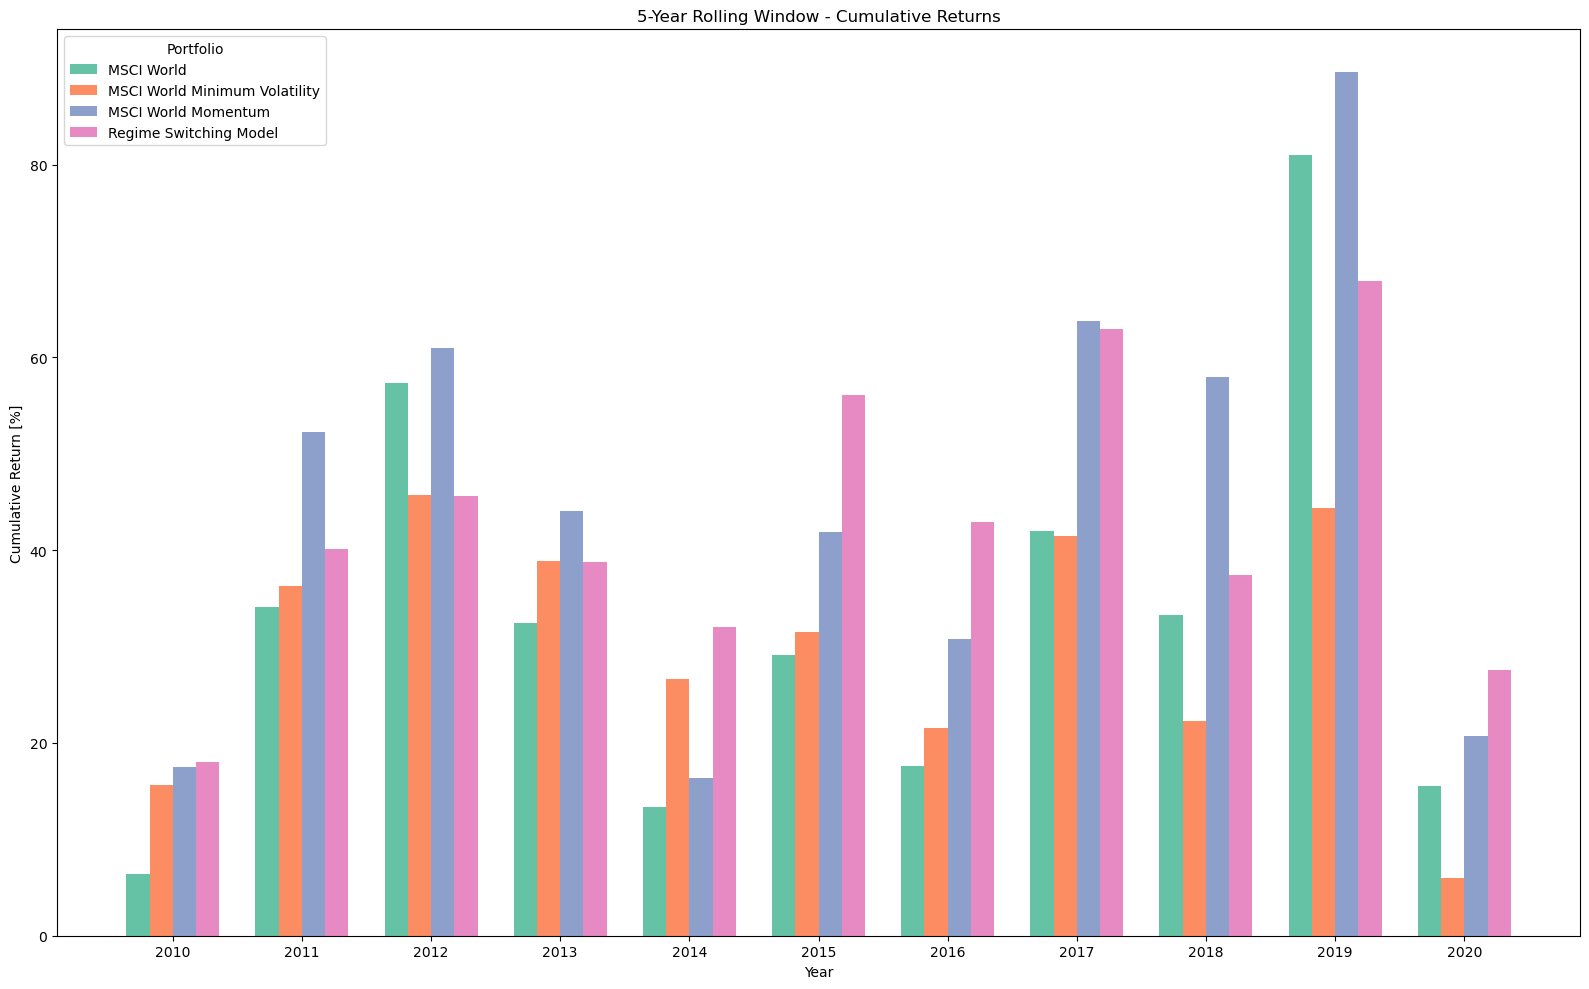

In [46]:
# Define the rolling window size (5 years)
window_size = 5 * 52

results_dict = {
    'Portfolio': [],
    'Year': [],
    'Cumulative Return': []
}

# Define the portfolios to analyze
portfolios = ['MSCI World', 'MSCI World Minimum Volatility', 'MSCI World Momentum', 'Regime Switching Model']


# Parse the start and end dates to get the years
start_year = pd.to_datetime(s_date).year
end_year = pd.to_datetime(e_date).year - 4  # Ensure there are at least 3 full years available

# Loop through each year from start_year to end_year
for year in range(start_year, end_year + 1):
    # Start and end dates for the current window
    start_date = f'{year}-01-01'
    end_date = f'{year + 2}-12-31'

    # Loop through each portfolio
    for portfolio in portfolios:
        # Filter the returns DataFrame to the current window
        window_returns = returns.loc[start_date:end_date]
        
        # Check if the window_returns DataFrame is not empty
        if not window_returns.empty and window_returns[portfolio].notna().all():
            cum_return = (1 + window_returns[portfolio]).cumprod().iloc[-1] - 1
        else:
            cum_return = float('nan')

        # Append the result to the dictionary
        results_dict['Portfolio'].append(portfolio)
        results_dict['Year'].append(year)
        results_dict['Cumulative Return'].append(cum_return)

# Convert the results to a DataFrame
results_df = pd.DataFrame(results_dict)

# Pivot the DataFrame to have each portfolio as a column
pivoted_df = results_df.pivot_table(index='Year', columns='Portfolio', values='Cumulative Return', aggfunc=np.sum)

# Create a palette of colors from "Set2"
palette = sns.color_palette("Set2", len(portfolios))

# Plot the results
plt.figure(figsize=(16,10))
bar_width = 0.18
years = pivoted_df.index
for i, portfolio in enumerate(portfolios):
    plt.bar(np.arange(len(years)) + i * bar_width, pivoted_df[portfolio]*100, bar_width, label=portfolio, color=palette[i])
plt.xticks(np.arange(len(years)) + (len(portfolios) - 1) * bar_width / 2, years)
plt.title('5-Year Rolling Window - Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Return [%]')
plt.legend(title='Portfolio', loc='upper left')
plt.tight_layout()
plt.savefig('images/rolling_5.png', dpi=300)
plt.show()


## Switch Efficiency

This section assess the switch efficiency by assessing the number of good switch, the relative performance of this selection and finally the cumulated outperformance of the regime allocation descision 

In [47]:
relatives['LOW-MOM_binary'] = (relatives['LOW-MOM'] > 0).astype(int)
relatives['LOW-MOM_binary'] = np.where(relatives['LOW-MOM'] > 0, 1, 0)
relatives['MOM-LOW_binary'] = (relatives['LOW-MOM'] > 0).astype(int)
relatives['MOM-LOW_binary'] = np.where(relatives['LOW-MOM'] > 0, 0, 1)

In [48]:
# Align the two DataFrames
aligned_rel, aligned_reg = relatives.align(expanding_regime)

# Compare the two columns and count the similarities and differences
same_count = ((aligned_rel['LOW-MOM_binary'] == aligned_reg['Regime 0']) & (aligned_rel['LOW-MOM_binary'] != None)).sum()
different_count = ((aligned_rel['LOW-MOM_binary'] != aligned_reg['Regime 0']) & (aligned_rel['LOW-MOM_binary'] != None)).sum()

print(f"Number of times the results are the same: {same_count}")
print(f"Number of times the results are different: {different_count}")

Number of times the results are the same: 368
Number of times the results are different: 669


In [49]:
expanding_regime =expanding_regime.loc[s_date:]
regime_comp = pd.DataFrame()
regime_comp['LOW_T'] = expanding_regime['Regime 1'] * expanding_regime['LOW_VOL_Return']
regime_comp['LOW_F'] = expanding_regime['Regime 0'] * expanding_regime['LOW_VOL_Return']
regime_comp['MOM_T'] = expanding_regime['Regime 0'] * expanding_regime['MOM_Return']
regime_comp['MOM_F'] = expanding_regime['Regime 1'] * expanding_regime['MOM_Return']
regime_comp.loc[s_date:]

,LOW_T,LOW_F,MOM_T,MOM_F
DATE,,,,
2010-12-05,0.002542,0.000000,0.000000,0.015915
2010-12-12,0.008926,0.000000,0.000000,0.013874
2010-12-19,0.010288,0.000000,0.000000,0.002858
2010-12-26,0.000000,0.005408,0.007195,0.000000
2011-01-02,0.000000,0.003951,0.000013,0.000000
...,...,...,...,...
2024-10-27,-0.014176,-0.000000,-0.000000,-0.008707
2024-11-03,-0.010667,-0.000000,-0.000000,-0.013034
2024-11-10,0.013611,0.000000,0.000000,0.017787


In [50]:
# Define the function to split the dataframe
def split_dataframe(df):
    dfs = []
    start_idx = 0
    # Iterate over the rows in the dataframe
    for i in range(1, len(df)):
        # Check if the sign of the 'LOW_T' value has changed
        if (df.iloc[i]['LOW_T'] != 0 and df.iloc[i-1]['LOW_T'] == 0) or \
           (df.iloc[i]['LOW_T'] == 0 and df.iloc[i-1]['LOW_T'] != 0):
            # Append the current dataframe to the list
            dfs.append(df.iloc[start_idx:i])
            # Update the start index
            start_idx = i
    # Append the last dataframe to the list
    dfs.append(df.iloc[start_idx:])  
    return dfs

# Split the dataframe
dfs = split_dataframe(regime_comp)

# Print
num_splits = len(dfs)
print(f"Number of splits: {num_splits}")

Number of splits: 83


In [51]:
# Calculate cumulative product for each column in each dataframe
cumulative_products = []
for i, df in enumerate(dfs):
    cum_product = df.add(1).cumprod().iloc[-1]-1
    start_date = df.index.min()
    end_date = df.index.max()
    cumulative_products.append({
        'Split': i+1,
        'Start Date': start_date,
        'End Date': end_date,
        'LOW_T': cum_product['LOW_T'],
        'LOW_F': cum_product['LOW_F'],
        'MOM_T': cum_product['MOM_T'],
        'MOM_F': cum_product['MOM_F']
    })

# Combine results into a single dataframe
split_perf = pd.DataFrame(cumulative_products)
split_perf.index = split_perf['Split']
split_perf = split_perf.drop(['Split'], axis=1)

In [52]:
best_asset = []
worst_asset = []
best_asset_value = []
worst_asset_value = []

# Iterate through each row in the result_df
for index, row in split_perf.iterrows():
    # Filter out zero values
    filtered_values = {col: x for col, x in zip(['LOW_T', 'LOW_F', 'MOM_T', 'MOM_F'], [row['LOW_T'], row['LOW_F'], row['MOM_T'], row['MOM_F']]) if x != 0}

    # Check if there are any valid values left after filtering
    if filtered_values:
        # Find the minimum and maximum values in the row
        min_value = min(filtered_values.values())
        max_value = max(filtered_values.values())

        # Get all column names corresponding to the minimum and maximum values
        worst_assets = [k for k, v in filtered_values.items() if v == min_value]
        best_assets = [k for k, v in filtered_values.items() if v == max_value]

        # Join all worst and best assets by comma
        worst_asset_name = ','.join(worst_assets) if worst_assets else None
        best_asset_name = ','.join(best_assets) if best_assets else None

        # Add the best and worst asset names and values to the lists
        best_asset.append(best_asset_name)
        worst_asset.append(worst_asset_name)
        best_asset_value.append(max_value)
        worst_asset_value.append(min_value)
    else:
        # If no valid values were found, set the best and worst assets and values to None or some other default value
        best_asset.append(None)
        worst_asset.append(None)
        best_asset_value.append(None)
        worst_asset_value.append(None)

# Add the best and worst asset columns to the result_df
split_perf['Best Asset'] =best_asset
split_perf['Worst Asset'] = worst_asset
split_perf['Best Asset Value'] = best_asset_value
split_perf['Worst Asset Value'] = worst_asset_value
split_perf['Good Switch'] = np.where((split_perf['Best Asset'] == 'MOM_T') | (split_perf['Best Asset'] == 'LOW_T'), 1, 0)
split_perf['Bad Switch'] = np.where((split_perf['Worst Asset'] == 'MOM_T') | (split_perf['Worst Asset'] == 'LOW_T'), 1, 0)
split_perf['Good Switch Value'] = split_perf['Good Switch']*(split_perf['Best Asset Value']- split_perf['Worst Asset Value'])
split_perf['Bad Switch Value'] = split_perf['Bad Switch']*(split_perf['Worst Asset Value']- split_perf['Best Asset Value'])
split_perf['Good Switch Value/time']= split_perf['Good Switch Value']/ (((split_perf['End Date'] - split_perf['Start Date']).dt.days+7) / 365.25)
split_perf['Bad Switch Value/time']= split_perf['Bad Switch Value']/ (((split_perf['End Date'] - split_perf['Start Date']).dt.days+7) / 365.25)

In [53]:
bad = split_perf['Bad Switch'].sum()
good = split_perf['Good Switch'].sum()
tot = split_perf['Bad Switch Value']+split_perf['Good Switch Value']
tot_time = split_perf['Bad Switch Value/time']+split_perf['Good Switch Value/time']
tot_sum = cumulative_product(tot)
print('The regime switching allows',good, 'good switchs for', bad, 'switchs', 'for a right switch ratio', f"{good/(good+bad):.2f}")

The regime switching allows 53 good switchs for 30 switchs for a right switch ratio 0.64


In [54]:
print(tot_time)

Split
1    -0.192294
2     0.040381
3     0.026314
4    -0.153995
5     0.094393
        ...   
79   -0.442608
80    0.436331
81    0.607628
82    0.537841
83   -0.367168
Length: 83, dtype: float64


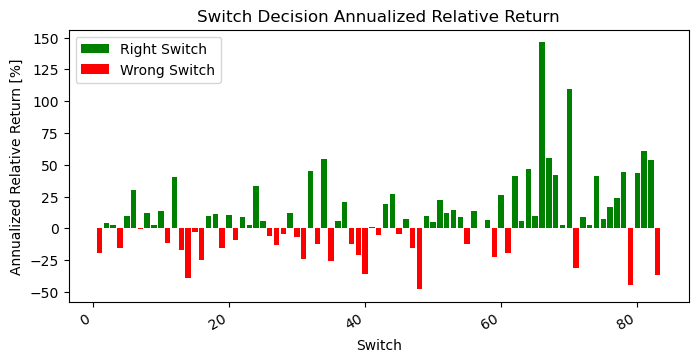

In [55]:
# Split the data into positive and negative values
positive_tot = tot_time[tot_time > 0]
negative_tot = tot_time[tot_time <= 0]


# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Bar plots for positive and negative values
ax.bar(positive_tot.index, positive_tot*100, color='green', label='Right Switch')
ax.bar(negative_tot.index, negative_tot*100, color='red', label='Wrong Switch')


# Set titles and labels
ax.set_title('Switch Decision Annualized Relative Return')
ax.set_xlabel('Switch')
ax.set_ylabel('Annualized Relative Return [%]')

# Format the x-axis to show dates properly
fig.autofmt_xdate()  # Rotates and right-aligns the x labels so they don't overlap

# Show legend
plt.legend()
plt.savefig('images/good_switch.png', dpi=300)
# Display the plot
plt.show()

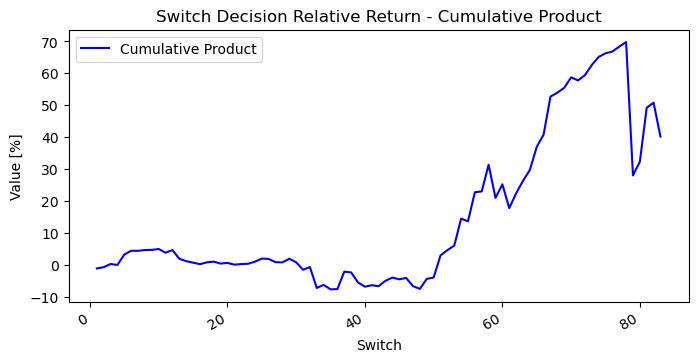

In [56]:
# Split the data into positive and negative values
positive_tot = tot_time[tot_time > 0]
negative_tot = tot_time[tot_time <= 0]


# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))



# Line plot for cumulative product
ax.plot(tot_sum.index, tot_sum*100, color='blue', label='Cumulative Product')

# Set titles and labels
ax.set_title('Switch Decision Relative Return - Cumulative Product')
ax.set_xlabel('Switch')
ax.set_ylabel('Value [%]')

# Format the x-axis to show dates properly
fig.autofmt_xdate()  # Rotates and right-aligns the x labels so they don't overlap

# Show legend
plt.legend()
plt.savefig('images/good_switch_cumprod.png', dpi=300)
# Display the plot
plt.show()

In [57]:
split_perf['Regime'] = split_perf.apply(lambda row: 'MOM' if row['MOM_T'] != 0 else 'LOW', axis=1)
split_reg = split_perf[['Start Date','End Date', 'Regime']]
split_reg.to_csv('tables/split_reg.csv', index=False)
split_reg.head(83)

,Start Date,End Date,Regime
Split,,,
1,2010-12-05,2010-12-19,LOW
2,2010-12-26,2011-01-23,MOM
3,2011-01-30,2011-06-12,LOW
4,2011-06-19,2011-06-19,MOM
5,2011-06-26,2011-10-23,LOW
...,...,...,...
79,2023-11-12,2024-05-26,LOW
80,2024-06-02,2024-06-23,MOM
81,2024-06-30,2024-09-08,LOW


## Perfect regime

This section simulates case where the investor knows in advance what the best choice is for each periods. It alllows to understand a bit the behavior of a prfect regime allocation case.

In [58]:
# assuming split_perf is your original DataFrame
perfect_regime = split_perf[['Start Date', 'End Date']].copy()

def get_perfect_regime(row):
    if row['Best Asset'] in ['MOM_T', 'MOM_F']:
        return 1
    else:
        return 0

perfect_regime['Perfect Regime 0'] = split_perf.apply(get_perfect_regime, axis=1)
perfect_regime['Perfect Regime 1'] = 1-perfect_regime['Perfect Regime 0'] 
perfect_regime.to_csv('tables/perfect_regime.csv', index=False)
print(perfect_regime)

      Start Date   End Date  Perfect Regime 0  Perfect Regime 1
Split                                                          
1     2010-12-05 2010-12-19                 1                 0
2     2010-12-26 2011-01-23                 1                 0
3     2011-01-30 2011-06-12                 0                 1
4     2011-06-19 2011-06-19                 0                 1
5     2011-06-26 2011-10-23                 0                 1
...          ...        ...               ...               ...
79    2023-11-12 2024-05-26                 1                 0
80    2024-06-02 2024-06-23                 1                 0
81    2024-06-30 2024-09-08                 0                 1
82    2024-09-15 2024-09-15                 1                 0
83    2024-09-22 2024-11-24                 1                 0

[83 rows x 4 columns]


In [59]:
# Create new columns in regimes_binary
regime_final['Perfect Regime 0'] = 0
regime_final['Perfect Regime 1'] = 0

for index, row in perfect_regime.iterrows():
    mask = ((regime_final.index >= row['Start Date']) &
            (regime_final.index <= row['End Date']))
    # Get the rows where the date falls within the range
    overlap_rows = regime_final[mask]
    if not overlap_rows.empty:
        if row['Perfect Regime 0'] == 0:
            regime_final.loc[mask, 'Perfect Regime 0'] = 0
        elif row['Perfect Regime 0'] == 1:
            regime_final.loc[mask, 'Perfect Regime 0'] = 1
        if row['Perfect Regime 1'] == 0:
            regime_final.loc[mask, 'Perfect Regime 1'] = 0
        elif row['Perfect Regime 1'] == 1:
            regime_final.loc[mask, 'Perfect Regime 1'] = 1

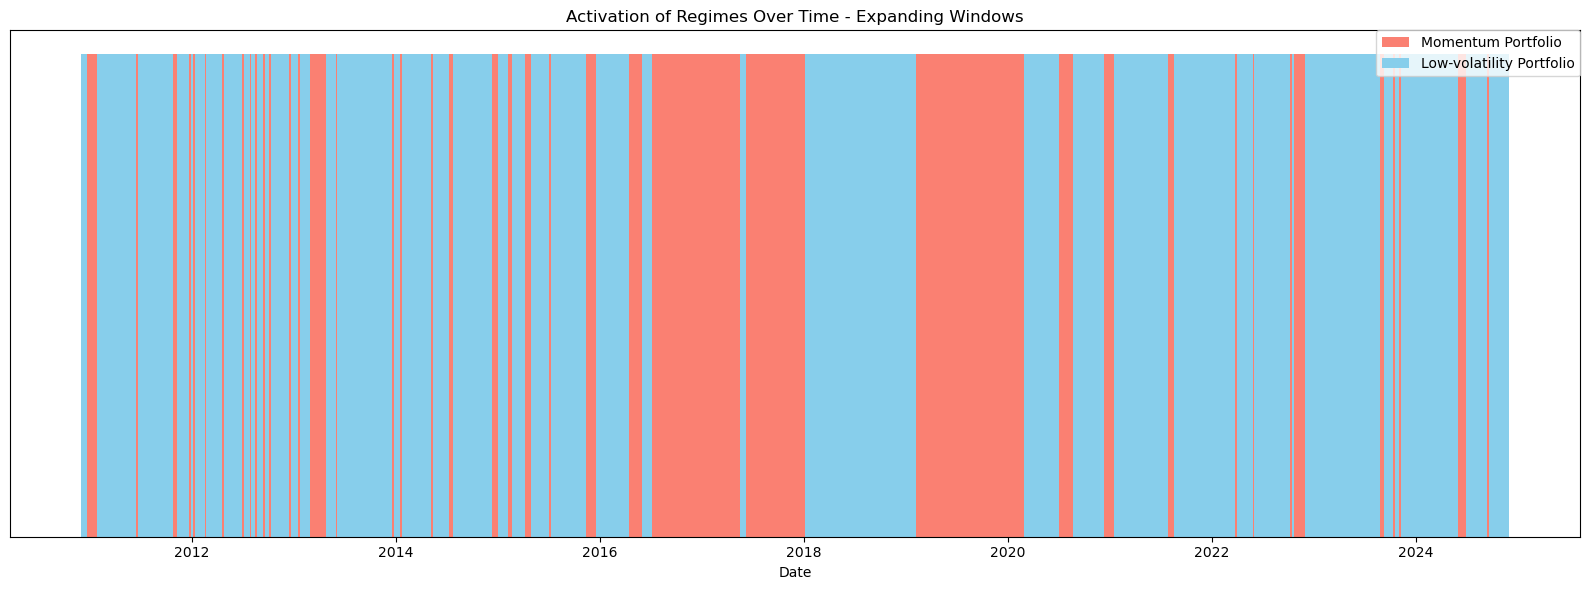

In [60]:
f.plot_regime_activation(regime_final,"Activation of Regimes Over Time - Expanding Windows")

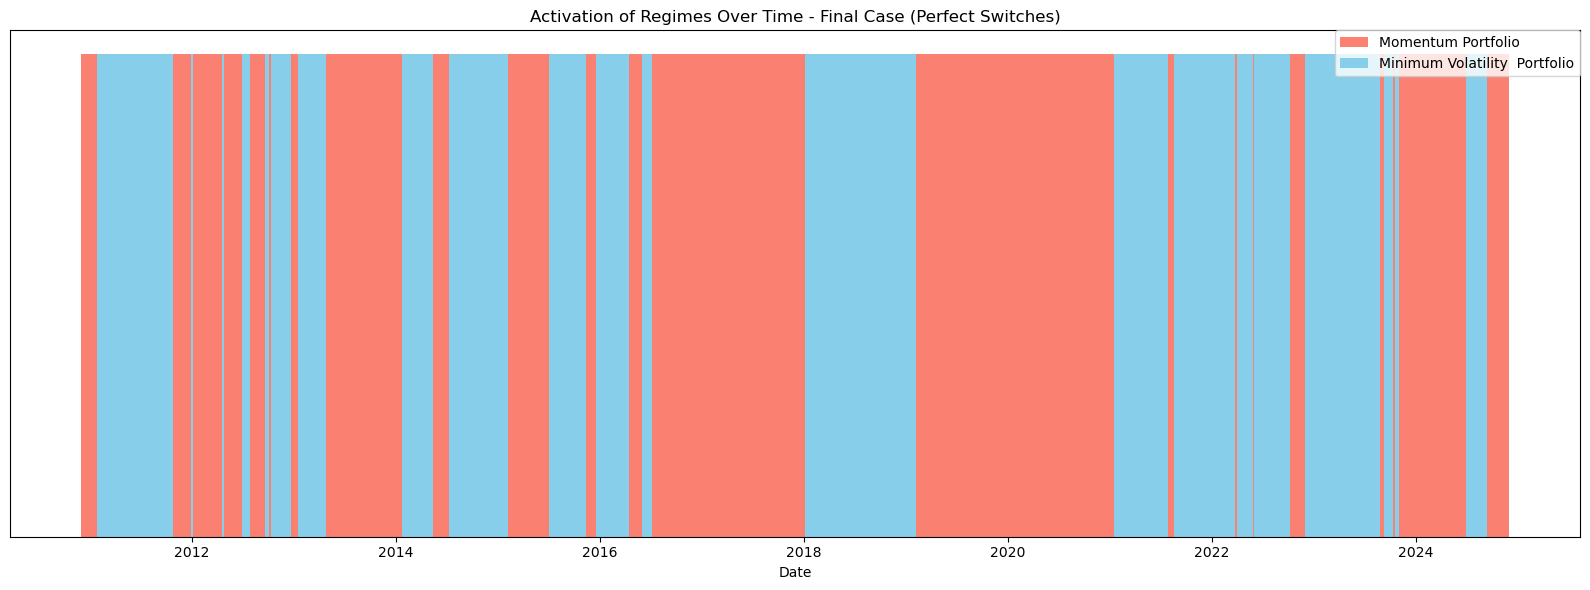

In [61]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20,6))

dates = regime_final.index

dates_dt = pd.to_datetime(dates)

width = (dates_dt[1] - dates_dt[0]).total_seconds() / (60 * 60 * 24)

regime_0 = regime_final['Perfect Regime 0']
regime_1 = regime_final['Perfect Regime 1']

heights = np.ones(len(dates))
colors = ['blue' if r0 == 1 else 'red' for r0, r1 in zip(regime_0, regime_1)]

regime_0_indices = [i for i, (r0, r1) in enumerate(zip(regime_0, regime_1)) if r0 == 1]
regime_1_indices = [i for i, (r0, r1) in enumerate(zip(regime_0, regime_1)) if r1 == 1]

ax.bar([dates_dt[i] for i in regime_0_indices], [heights[i] for i in regime_0_indices], width=width, color='salmon', label='Momentum Portfolio')
ax.bar([dates_dt[i] for i in regime_1_indices], [heights[i] for i in regime_1_indices], width=width, color='skyblue', label='Minimum Volatility  Portfolio')
ax.set_title("Activation of Regimes Over Time - Final Case (Perfect Switches)")
ax.set_xlabel("Date")
ax.set_ylabel("")
ax.set_yticks([])
ax.legend(loc='upper right', borderaxespad=0.)
fig.tight_layout(rect=[0,0,0.8,1]) 
plt.savefig('images/Activation of Regimes Over Time - Final Case (Perfect Switches).png', dpi=300)
plt.show()

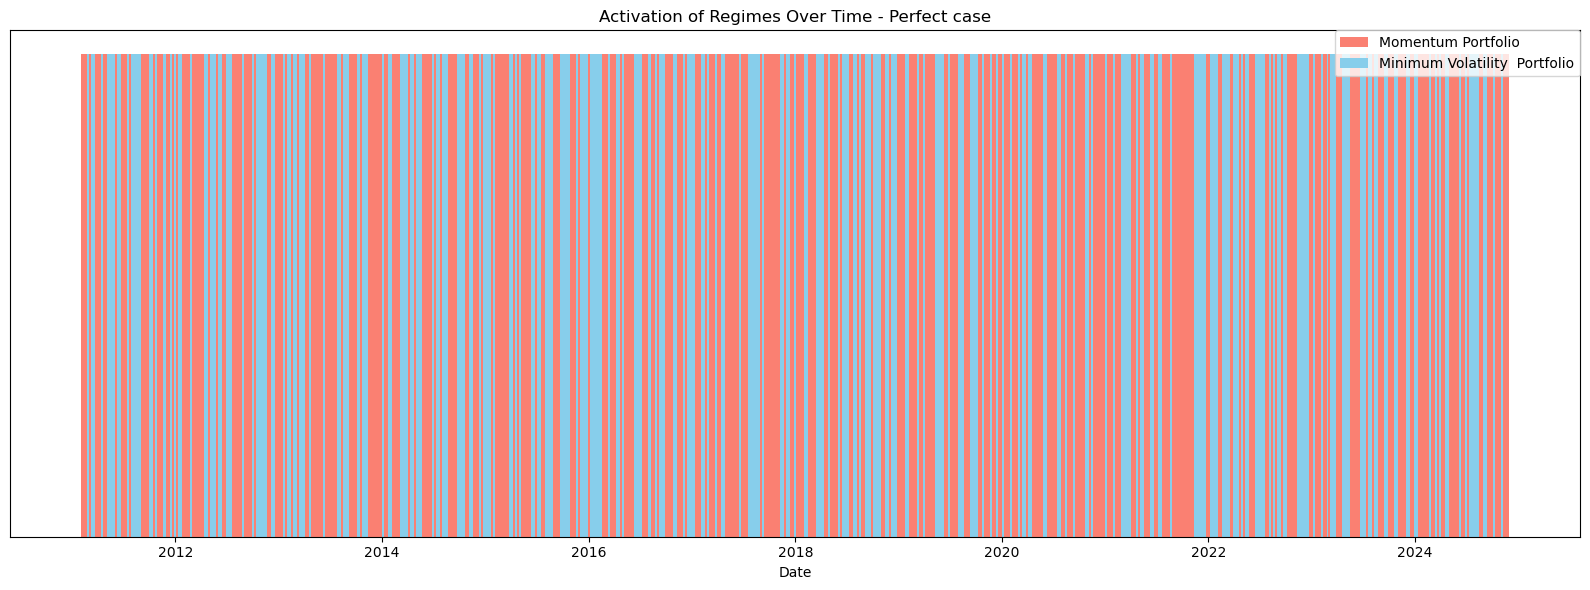

In [62]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20,6))

dates = relatives.index

dates_dt = pd.to_datetime(dates)

width = (dates_dt[1] - dates_dt[0]).total_seconds() / (60 * 60 * 24)

regime_0 = relatives['LOW-MOM_binary']
regime_1 = relatives['MOM-LOW_binary']

heights = np.ones(len(dates))
colors = ['blue' if r0 == 1 else 'red' for r0, r1 in zip(regime_0, regime_1)]

regime_0_indices = [i for i, (r0, r1) in enumerate(zip(regime_0, regime_1)) if r0 == 1]
regime_1_indices = [i for i, (r0, r1) in enumerate(zip(regime_0, regime_1)) if r1 == 1]

ax.bar([dates_dt[i] for i in regime_0_indices], [heights[i] for i in regime_0_indices], width=width, color='salmon', label='Momentum Portfolio')
ax.bar([dates_dt[i] for i in regime_1_indices], [heights[i] for i in regime_1_indices], width=width, color='skyblue', label='Minimum Volatility  Portfolio')
ax.set_title("Activation of Regimes Over Time - Perfect case")
ax.set_xlabel("Date")
ax.set_ylabel("")
ax.set_yticks([]) 
ax.legend(loc='upper right', borderaxespad=0.)
fig.tight_layout(rect=[0,0,0.8,1])
plt.savefig('images/Activation of Regimes Over Time - Expanding Windows (Perfect case & infinite switch).png', dpi=300)
plt.show()

# Worst Drawdown scenario

In Worst Off scenario, the goal is to assess the startegy behavior in a worst drawdown scenario to assesses its resilience

In [63]:
returns_wo = returns.loc[s_date:]

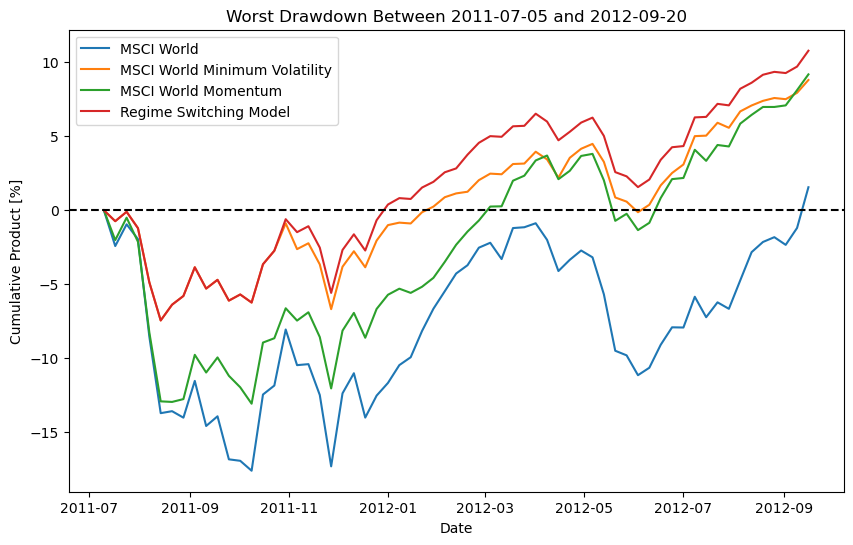

In [64]:
# Assuming 'cumulative_prod' is your DataFrame with dates as index and strategies as columns
start_date = '2011-07-05'
end_date = '2012-09-20'

# Slice data by date range
returns_slice = returns.loc[start_date:end_date]
returns_slice = cumulative_product(returns_slice)*100

# Subtract the initial value from each column
initial_values = returns_slice.iloc[0].copy()  # Get the values on the first row
returns_slice_subtracted = returns_slice.sub(initial_values)

# Plotting
plt.figure(figsize=(10,6))
for col in returns_slice_subtracted.columns:
    plt.plot(returns_slice_subtracted.index, returns_slice_subtracted[col], label=col)

plt.axhline(0, color='black', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Date')
plt.ylabel('Cumulative Product [%]')
plt.title('Worst Drawdown Between {} and {}'.format(start_date, end_date))
plt.legend()
plt.savefig('images/WD - 2011-2012.png', dpi=300)
plt.show()

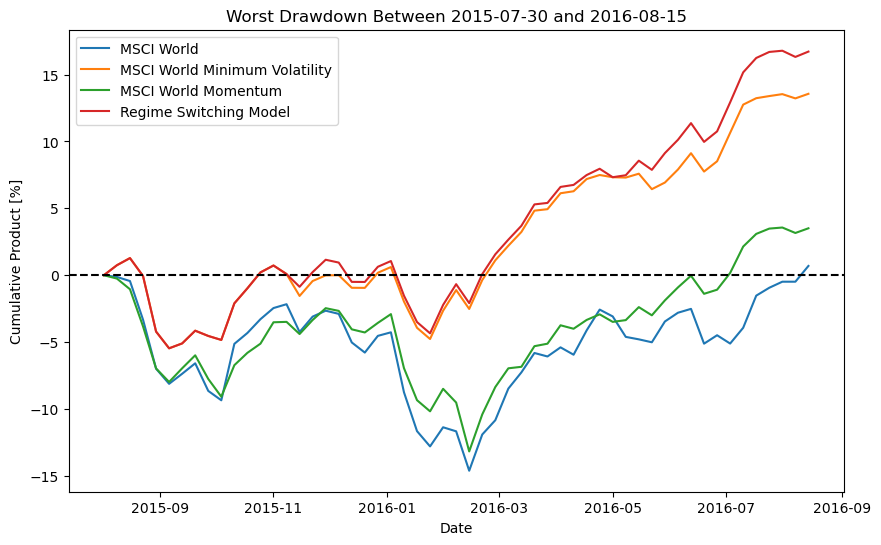

In [65]:
# Assuming 'cumulative_prod' is your DataFrame with dates as index and strategies as columns
start_date = '2015-07-30'
end_date = '2016-08-15'

# Slice data by date range
returns_slice = returns.loc[start_date:end_date]
returns_slice = cumulative_product(returns_slice)*100

# Subtract the initial value from each column
initial_values = returns_slice.iloc[0].copy()  # Get the values on the first row
returns_slice_subtracted = returns_slice.sub(initial_values)

# Plotting
plt.figure(figsize=(10,6))
for col in returns_slice_subtracted.columns:
    plt.plot(returns_slice_subtracted.index, returns_slice_subtracted[col], label=col)

plt.axhline(0, color='black', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Date')
plt.ylabel('Cumulative Product [%]')
plt.title('Worst Drawdown Between {} and {}'.format(start_date, end_date))
plt.savefig('images/WD - 2015-2016.png', dpi=300)
plt.legend()
plt.show()

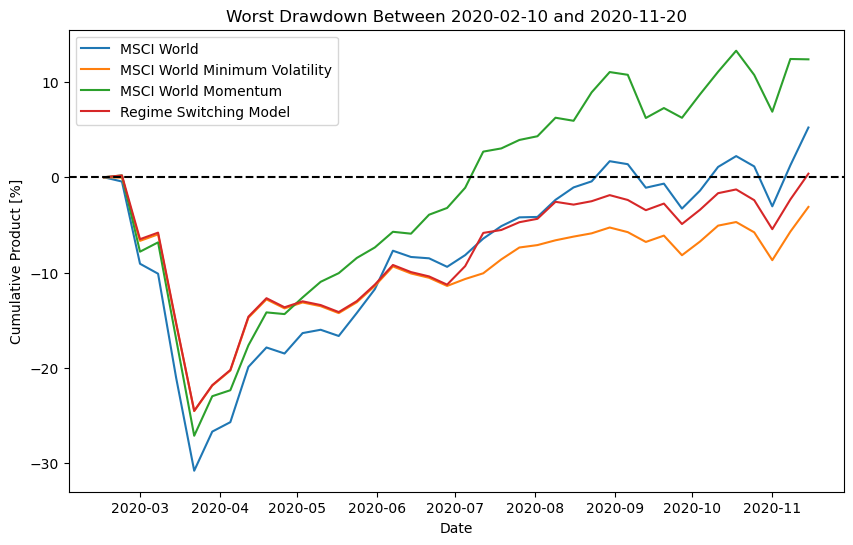

In [66]:
# Assuming 'cumulative_prod' is your DataFrame with dates as index and strategies as columns
start_date = '2020-02-10'
end_date = '2020-11-20'

# Slice data by date range
returns_slice = returns.loc[start_date:end_date]
returns_slice = cumulative_product(returns_slice)*100

# Subtract the initial value from each column
initial_values = returns_slice.iloc[0].copy()  # Get the values on the first row
returns_slice_subtracted = returns_slice.sub(initial_values)

# Plotting
plt.figure(figsize=(10,6))
for col in returns_slice_subtracted.columns:
    plt.plot(returns_slice_subtracted.index, returns_slice_subtracted[col], label=col)

plt.axhline(0, color='black', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Date')
plt.ylabel('Cumulative Product [%]')
plt.title('Worst Drawdown Between {} and {}'.format(start_date, end_date))
plt.legend()
plt.savefig('images/WD - 2019-2020.png', dpi=300)
plt.show()

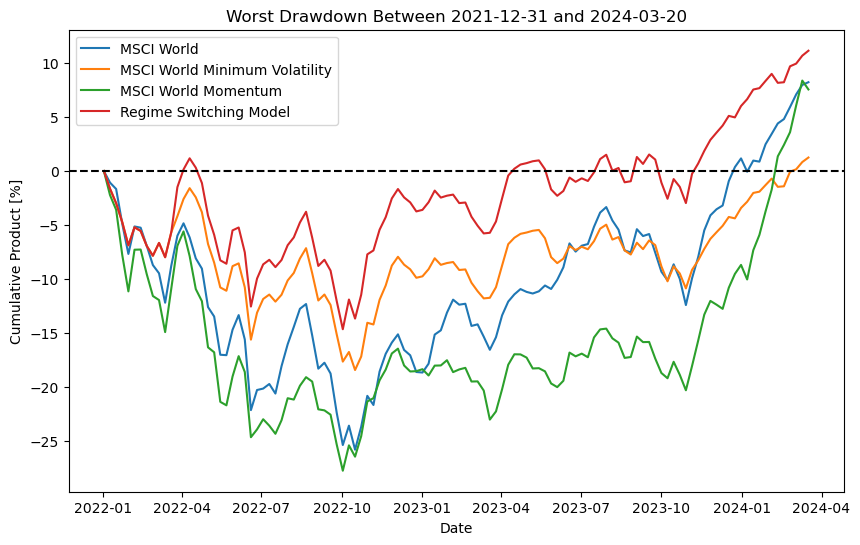

In [67]:
# Assuming 'cumulative_prod' is your DataFrame with dates as index and strategies as columns
start_date = '2021-12-31'
end_date = '2024-03-20'

# Slice data by date range
returns_slice = returns.loc[start_date:end_date]
returns_slice = cumulative_product(returns_slice)*100

# Subtract the initial value from each column
initial_values = returns_slice.iloc[0].copy()  # Get the values on the first row
returns_slice_subtracted = returns_slice.sub(initial_values)

# Plotting
plt.figure(figsize=(10,6))
for col in returns_slice_subtracted.columns:
    plt.plot(returns_slice_subtracted.index, returns_slice_subtracted[col], label=col)

plt.axhline(0, color='black', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Date')
plt.ylabel('Cumulative Product [%]')
plt.title('Worst Drawdown Between {} and {}'.format(start_date, end_date))
plt.legend()
plt.savefig('images/WD - 2021-2024.png', dpi=300)
plt.show()